In [1]:
# all necessary packages
library(cobalt)
library(dplyr)
library(ggplot2)
library(dagitty)
library(stargazer)
library(MatchIt)
library(rdrobust)
library(IRdisplay)
library(Synth)

Warning message:
"package 'cobalt' was built under R version 4.1.3"
 cobalt (Version 4.4.1, Build Date: 2022-11-03)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'dagitty' was built under R version 4.1.3"

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Warning message:
"package 'MatchIt' was built under R version 4.1.3"

Attaching package: 'MatchIt'


The following object is masked from 'package:cobalt':

    lalonde


Warning message:
"package 'rdrobust' was built under R version 4.1.3"
Warning message:
"package 'IRdisplay' was built under R version 4.1.3"
Warning message:
"package 'Synth' was built under R version 4.1.3"
##
## Synth Package: Implements Synthetic Control

# QUESTION 1: World Bank Health Insurance

This question uses a hypothetical dataset of a health insurance program that is used in the World Bank's Impact Evaluation in Practice book. This imaginary Health Insurance Subsidy Program (HISP) provides subsidies for buying private health insurance for poor households and it aims to lower personal health expenditures. The causal question we intend to answer here is the effect of enrollment in HISP on health expenditures and the units of analysis are households.

The dataset includes a number of important variables you'll use throughout this assignment. It also includes several demographic variables about the households. Let's assume each of these are backdoor confounders between health expenditures (outcome) and participation in  HISP (treatment).

- health_expenditures: Out-of-pocket health expenditures (per person per year)
- eligible: Households eligible to enroll in HISP
- enrolled: Household enrolled in HISP
- round: Indicator for before and after intervention
- poverty_index: 1-100 scale of poverty
- promotion_locality: The household is located in a community that received the random promotion
- age_hh: Age of the head of household (years)
- age_sp: Age of the spouse (years)
- educ_hh: Education of the head of household (years)
- educ_sp: Education of the spouse (years)
- female_hh: Head of household is a woman (1 = yes) 
- indigenous: Head of household speaks an indigenous language (1 = yes)
- hhsize: Number of household members
- dirtfloor: Home has a dirt floor (1 = yes)
- bathroom: The home has a private bathroom (1 = yes)
- land: Number of hectares of land owned by household
- hospital_distance: Distance to the closest hospital (km)

You will use each of the five main econometric approaches for estimating causal effects to measure the effect of HISP on household health expenditures. You'll use both the regression discontinuity method and the difference-in-difference method. Don't worry about conducting in-depth baseline checks. For the sake of this assignment, you'll do the minimum amount of work for each method to determine the causal effect of the program.

Let's first load the data and clean it. Scroll through the wrangling code to see what it's doing.

In [2]:
world_bank_raw = read.csv("https://raw.githubusercontent.com/ahdvnd/ss154-data/main/world_bank_data.csv")

# Make nice clean dataset to use for the rest of the assignment
# the following code is mainly for re factoring (Setting base categories and stuff) for factor variables in the data.
world_bank = world_bank_raw %>% 
  # Having a numeric 0/1 column is sometimes helpful for things that don't like
  # categories, like matchit()
  mutate(enrolled_num = enrolled) %>% 
  # Convert these 0/1 values to actual categories
  mutate(eligible = factor(eligible, labels = c("Not eligible", "Eligible")),
         enrolled = factor(enrolled, labels = c("Not enrolled", "Enrolled")),
         round = factor(round, labels = c("Before", "After")),
         promotion_locality = factor(promotion_locality, labels = c("No promotion", "Promotion"))) %>% 
  # Get rid of this hospital column because (1) we're not using it, and (2) half
  # of the households are missing data, and matchit() complains if any data is
  # missing, even if you're not using it
  select(-hospital)

## Step 1: Checking for selection bias

Let's see if households in the "treatment" groups were fundamentally different than households in the "control" group. Check the outcome variable and at least 3 of the covariates before the treatment happened (round == "Before"). Name this dataset world_bank_before. Note that the treatment variable is enrolled and the outcome variable is health_expenditures. 

For this step, you can either show the difference in means between treatment and control OR show the distributions of treatment and control for each of the variables and the outcome OR use the cobalt package (any of the dataviz functions are good) to do it for you.

1. Why did you choose the three variables you chose?
2. Are the variables fairly balanced before treatment?

To answer this question, other than the information above, we can also use a Directed Acyclic Graph (DAG) which allows visualization of the paths between the variables. DAGs allow us to identify backdoor paths, direct paths, and collider paths allowing us to realize which variables we need to control for. DAGs have limitations when there are unknown confounders as they can give a false sense of confidence about information that we don't actually have making us beleive that we are controlling for all covariates but gaps in knowledge such as unknown confounders or wrong pathway assumptions can lead to biased results. However, here DAGs can allow a visualization of the various pathways between variables allowing us to identify which variables we need to control for to estimate a causal effect.

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.



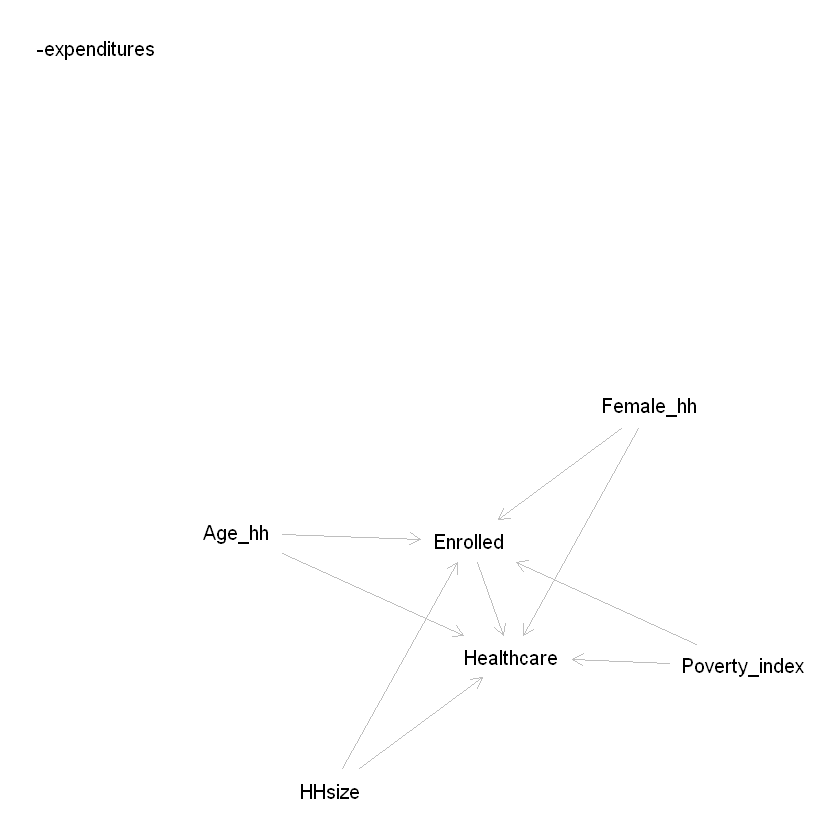

In [3]:
# make a dag
dag = dagitty("dag {
    Enrolled -> Healthcare-expenditures
    Poverty_index -> Healthcare-expenditures
    Poverty_index -> Enrolled
    Female_hh -> Enrolled
    Female_hh -> Healthcare-expenditures
    Age_hh -> Enrolled
    Age_hh -> Healthcare-expenditures
    HHsize -> Enrolled
    HHsize -> Healthcare-expenditures}")

# plot the dag
plot(dag)

The variables that I chose for this are:  
- poverty_index
- female_hh
- age_hh
- hhsize

The reason I chose these variables are because they are potential confounders that could affect both treatment and outcome variables as shown in the DAG above(simplified to avoid clutter).  
The poverty_index variable is a measure of household poverty and thus could affect both the eligbility for the program and the expenditures on health.  
The female_hh is a binary variable indicating whether or not the head of the household is a female which could also affect both the eligibility for the program and the expenditures on health as women tend to spend more on health as compared to men (Owens, 2008). 
The hhsize variable is a continuous variable indicating the number of household members which could also affect both the eligibility for the program and the expenditures on health as households might need a minimum number of members to be eligible for the program as well as bigger households might need more health care.
Finally, the age_hh variable is a continuous variable indicating the age of the head of the household which could also affect both the eligibility for the program and the expenditures on health as older people are more likely to have health issues.  
Now, let's check the balance of the variables before treatment.

In [4]:
world_bank_before <- world_bank %>%
  filter(round == "Before") %>%
  select(enrolled, health_expenditures, poverty_index, female_hh, age_hh, hhsize)

summary(world_bank_before)

         enrolled    health_expenditures poverty_index      female_hh      
 Not enrolled:6949   Min.   : 6.252      Min.   : 20.48   Min.   :0.00000  
 Enrolled    :2964   1st Qu.:13.022      1st Qu.: 49.65   1st Qu.:0.00000  
                     Median :16.839      Median : 56.41   Median :0.00000  
                     Mean   :17.211      Mean   : 56.79   Mean   :0.09906  
                     3rd Qu.:21.053      3rd Qu.: 62.91   3rd Qu.:0.00000  
                     Max.   :35.626      Max.   :100.00   Max.   :1.00000  
     age_hh         hhsize      
 Min.   :14.0   Min.   : 1.000  
 1st Qu.:34.0   1st Qu.: 4.000  
 Median :45.0   Median : 5.000  
 Mean   :46.2   Mean   : 5.179  
 3rd Qu.:57.0   3rd Qu.: 7.000  
 Max.   :88.0   Max.   :13.000  

In [5]:
# I commented out the code for plotting the means against each other because the plots make the workbook quite long. 
# If you want to visualize the means comparison between the groups, you can uncomment the code below.


# Filter for before treatment
world_bank_before <- filter(world_bank, round == "Before")

# Calculate means for treatment and control groups
means_table <- world_bank_before %>%
  group_by(enrolled) %>%
  summarize(mean_expenditures = mean(health_expenditures),
            mean_poverty_index = mean(poverty_index),
            mean_age_hh = mean(age_hh),
            mean_female_hh = mean(female_hh),
            mean_hhsize = mean(hhsize))
# display the means table
means_table
# Plot means for each variable
# ggplot(means_table, aes(x = enrolled, y = mean_expenditures)) +
#   geom_col(fill = "blue", alpha = 0.5) +
#   labs(x = "Enrollment in HISP", y = "Mean health expenditures (before treatment)")

# ggplot(means_table, aes(x = enrolled, y = mean_poverty_index)) +
#   geom_col(fill = "blue", alpha = 0.5) +
#   labs(x = "Enrollment in HISP", y = "Mean poverty index (before treatment)")

# ggplot(means_table, aes(x = enrolled, y = mean_age_hh)) +
#   geom_col(fill = "blue", alpha = 0.5) +
#   labs(x = "Enrollment in HISP", y = "Mean age of head of household (before treatment)")

# ggplot(means_table, aes(x = enrolled, y = mean_female_hh)) +
#   geom_col(fill = "blue", alpha = 0.5) +
#   labs(x = "Enrollment in HISP", y = "Proportion of female heads of household (before treatment)")


enrolled,mean_expenditures,mean_poverty_index,mean_age_hh,mean_female_hh,mean_hhsize
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Not enrolled,18.37171,59.97223,48.13844,0.11008778,4.926320
Enrolled,14.48969,49.33071,41.65658,0.07321188,5.769906


Looking at the table above, we can compare the means across the various variables that we chose. It seems that while not perfectly balanced across the treatment and control groups, the variables are fairly balanced before treatment. The means aren't too far apart and roughly lie in the same group for both treatment and control groups. This is a debateable assumption as the means are not exactly the same but it is a good enough assumption for this assignment.  
The means of the poverty_index variable are 59.97 compared to 49.33 and while this seems like a big gap objectively, the relative poverty of the two households is still probably comparable as the quality of life in the two households is probably close. The means will be slightly different as the not enrolled group also includes the higher end of the households on that scale which drive the mean up.  
Similarly, the mean age of head of household is 48.13 in the control group and 41.66 in the treatment group. As both of those lie in the same age group of 40s, they are fairly balanced.  
The female_hh variable is also fairly balanced as the means are 0.11 and 0.07 respectively. This is not a big change across the two groups.  
The hhsize variable is also fairly balanced as the means are 4.92 and 5.76 respectively. This is not a big change across the groups as both of these are relatively big values for the number of household members.  

We can compare the distributions of the two groups across these variables as a further check as well.

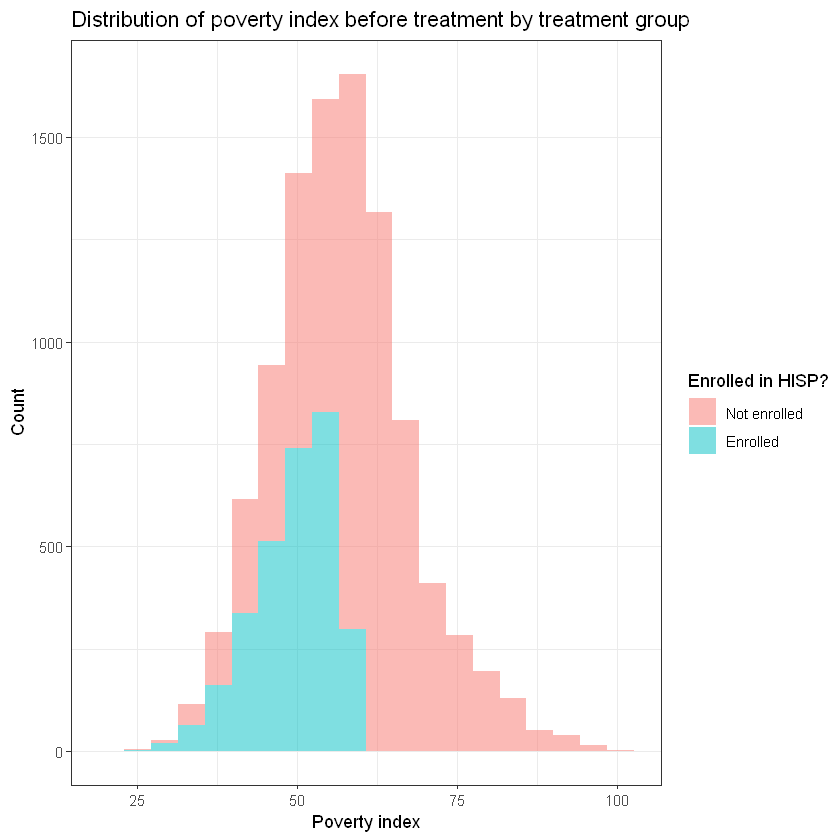

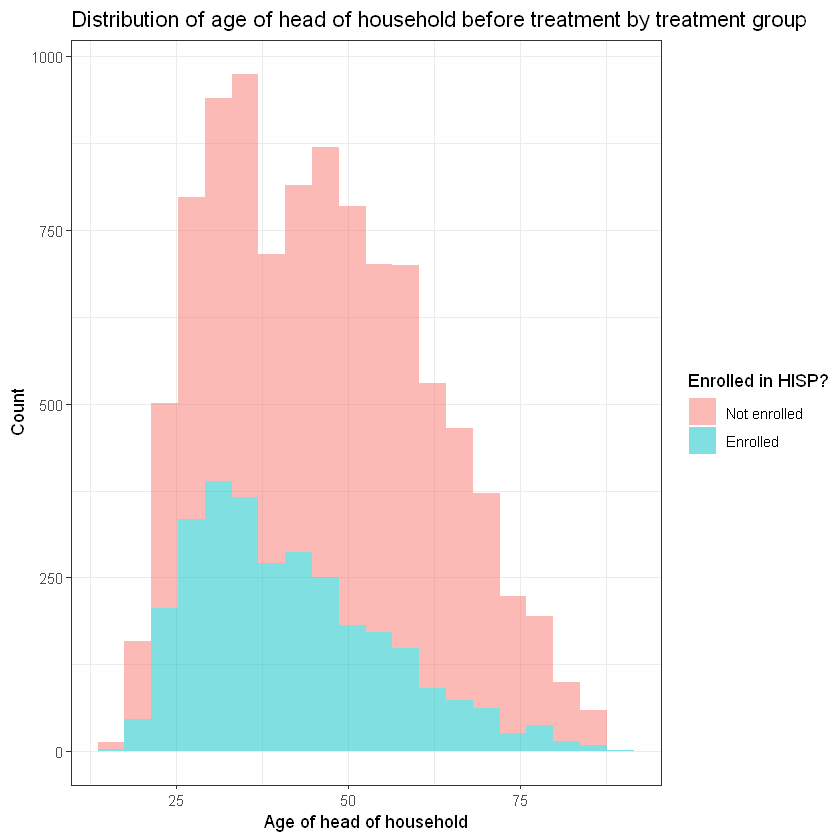

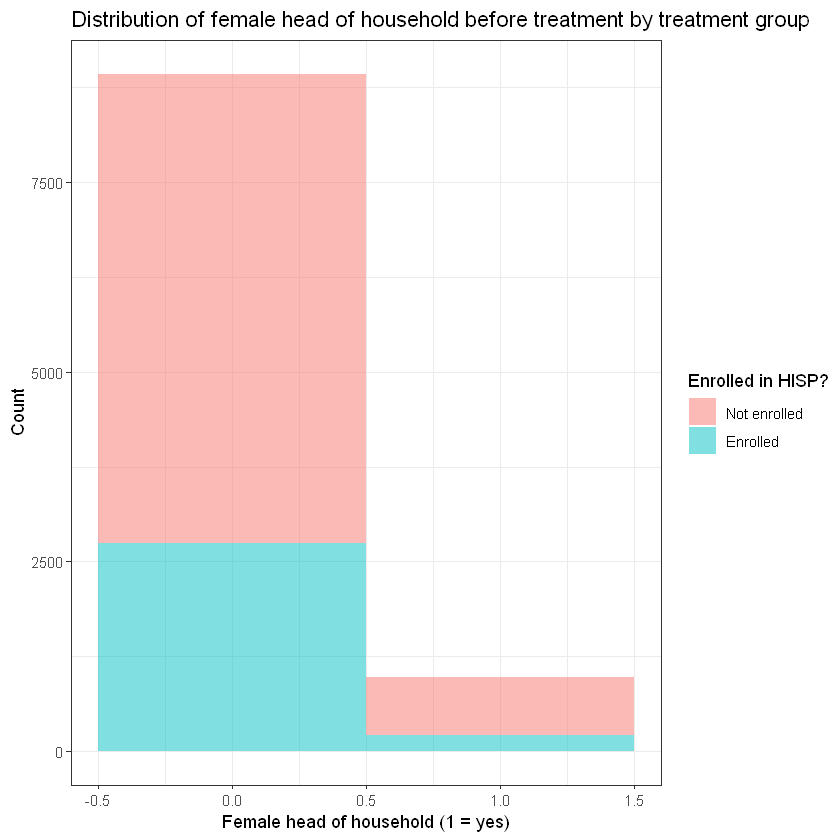

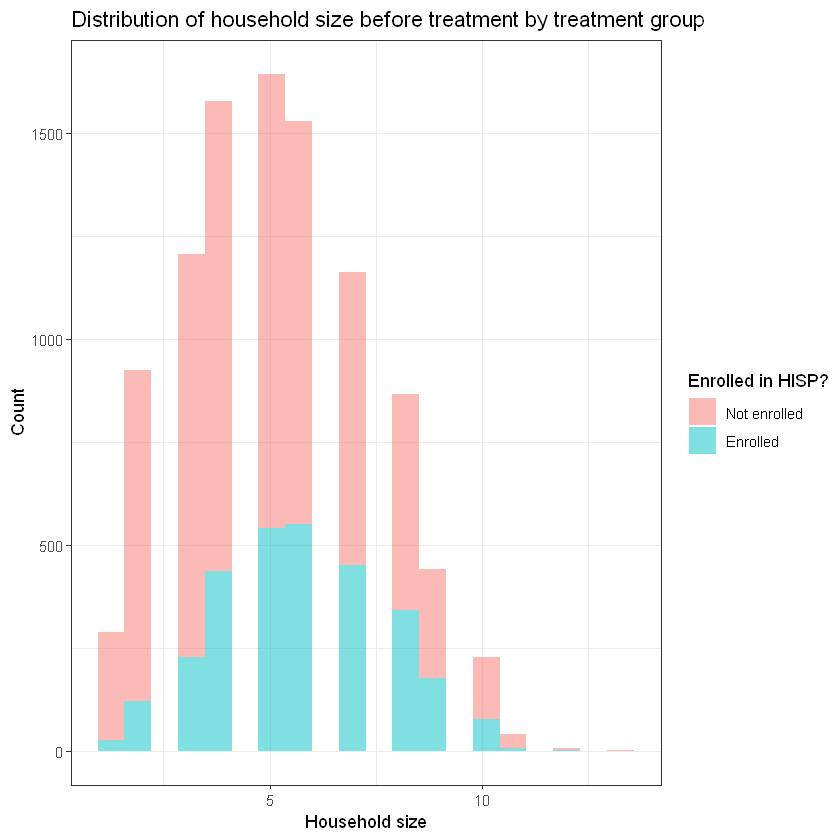

In [6]:
# This is the outcome variable and thus the distribution is not needed for this question. It is still a good visualization though.
# world_bank_before %>%
#   filter(round == "Before") %>%
#   ggplot(aes(x = health_expenditures, fill = enrolled)) +
#   geom_histogram(alpha = 0.5, bins = 20) +
#   labs(title = "Distribution of health expenditures before treatment by treatment group",
#        x = "Health expenditures",
#        y = "Count",
#        fill = "Enrolled in HISP?") +
#   theme_bw()

world_bank_before %>%
  filter(round == "Before") %>%
  ggplot(aes(x = poverty_index, fill = enrolled)) +
  geom_histogram(alpha = 0.5, bins = 20) +
  labs(title = "Distribution of poverty index before treatment by treatment group",
       x = "Poverty index",
       y = "Count",
       fill = "Enrolled in HISP?") +
  theme_bw()

world_bank_before %>%
  filter(round == "Before") %>%
  ggplot(aes(x = age_hh, fill = enrolled)) +
  geom_histogram(alpha = 0.5, bins = 20) +
  labs(title = "Distribution of age of head of household before treatment by treatment group",
       x = "Age of head of household",
       y = "Count",
       fill = "Enrolled in HISP?") +
  theme_bw()

world_bank_before %>%
  filter(round == "Before") %>%
  ggplot(aes(x = female_hh, fill = enrolled)) +
  geom_histogram(alpha = 0.5, bins = 2) +
  labs(title = "Distribution of female head of household before treatment by treatment group",
       x = "Female head of household (1 = yes)",
       y = "Count",
       fill = "Enrolled in HISP?") +
  theme_bw()

world_bank_before %>%
     filter(round == "Before") %>%
     ggplot(aes(x = hhsize, fill = enrolled)) +
     geom_histogram(alpha = 0.5, bins = 20) +
     labs(title = "Distribution of household size before treatment by treatment group",
           x = "Household size",
           y = "Count",
           fill = "Enrolled in HISP?") +
     theme_bw()


Looking at the distributions above, we can see that the reasons we identified from the means above seem to be true. The distriutions across the two groups are fairly similar and the differences are not too big other than poverty index where we can see that since the households at the upper end of the scale are included, the mean is driven up. Other than that, the other variables seem to be fairly balanced across the two groups as they follow similar trends as you can see when you compare the blue and pink distributions above. The count of the enrolled group is obviously smaller so the distributions are not perfectly the same.

## Step 2: Naive Causal Effect

Make a new dataset that only looks at households after the experiment (round == "After"). Name this dataset world_bank_after.

1. Using this newly created dataset, calculate the naive causal effect after the treatment happened by running a simple regression of outcome on treatment. Note that the outcome variable is health_expenditures and the treatment variable is enrolled. You can estimate the native effect by comparing the average of health_expenditures across treatment and control groups.
2. What's the interpretation of the treatment effect? Does it make sense? 
3. What is the issue with this number? 

NOTE: For better readability, please also number your answers to each part so it's clear to which question they're referring.

In [7]:
world_bank_after <- world_bank %>% filter(round == "After")

naive_effect_model <- lm(health_expenditures ~ enrolled_num, data = world_bank_after)
summary(naive_effect_model)

# We can also compare averages after the treatment between control and treatment groups
treat_average <- mean(world_bank_after$health_expenditures[world_bank_after$enrolled_num == 1])
control_average <- mean(world_bank_after$health_expenditures[world_bank_after$enrolled_num == 0])
naive_effect <- treat_average - control_average
naive_effect


Call:
lm(formula = health_expenditures ~ enrolled_num, data = world_bank_after)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.501  -6.829  -2.733   3.680  96.123 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   20.7075     0.1239  167.13   <2e-16 ***
enrolled_num -12.8673     0.2266  -56.79   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 10.33 on 9912 degrees of freedom
Multiple R-squared:  0.2455,	Adjusted R-squared:  0.2454 
F-statistic:  3225 on 1 and 9912 DF,  p-value: < 2.2e-16


[1] -12.86728

1. We created the dataset that contains only values of after the treatment. We ran a regression of the outcome variable on the treatment variable as well as compared that to the average of the outcome variable across the treatment and control groups. The naive causal effect can be seen as the coefficient of the **enrolled_num** variable in the regression output or the number at the end which are both the same and is -12.867.
2. The interpretation of the treatment effect in this case is that on average, households enrolled in the HISP had health expenditures that were different from those that didn't enroll. Specifically, the negative effect of -12.86 means that the program decreased health expenditures by 12.86 per person per year on average. This makes sense as the program was meant to decrease health expenditures by providing free health care to the households that enrolled in the program.
3. The issue with this number is that it doesn't necessarily represent the causal effect of the program. This is because the enrolled households could systematically differ from those that did not enroll in ways that affect the health expenditures, even in the absence of the program. Simply put, there could be confounders in this study that we didn't control gor. For example, enrolled households may have higher healthcare needs or be more likely to live in areas with higher health costs. This could lead to selection bias indicating that the difference in the two groups is not just because of the program but also due to pre-existing differences between the two groups. Therefore, the naive causal effect may be balanced. Looking at the DAG we made for question 1, we are trying to estimate the effect of enrollemnt on expenditures which is the main path of the DAG but there are also backdoor paths which could be biasing the results. These paths need to be blocked which we can do by controlling for the variables.

**Confounding variables in the current DAG:** Age_hh, Female_hh, HHsize, Poverty_index  
**Backdoor paths:**  
- Enrolled <- Age_hh -> Expenditures
- Enrolled <- Female_hh -> Expenditures
- Enrolled <- HHsize -> Expenditures
- Enrolled <- Poverty_index -> Expenditures  

All of these paths need to be blocked so that we can estimate the effect of the main path which is the effect of enrollment on expenditures:
- Enrolled -> Expenditures

## Step 3: Controlling for Confounders

Now, let's create another model that controls for the following variables: age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance. Use the world_bank_after dataset.

Show the results from the two regressions (the one from step 2 and this one) in a side-by-side table using the stargazer package.
Does the estimate of the causal effect change? Why?

NOTE: For better readability, please also number your answers to each part so it's clear to which question they're referring.

In [8]:
# model with controlled variables
model_controlled <- lm(health_expenditures ~ enrolled_num + age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance, data = world_bank_after)
# naive model
model_naive <- lm(health_expenditures ~ enrolled_num, data = world_bank_after)
# display the models using stargazer
stargazer(model_naive, model_controlled, type = "text", title="Regression results", column.labels = c("Naive model", "With covariates"))


Regression results
                                     Dependent variable:                  
                    ------------------------------------------------------
                                     health_expenditures                  
                            Naive model              With covariates      
                                (1)                        (2)            
--------------------------------------------------------------------------
enrolled_num                -12.867***                  -10.005***        
                              (0.227)                    (0.211)          
                                                                          
age_hh                                                   0.074***         
                                                         (0.011)          
                                                                          
age_sp                                                    -0.015          
     

2. Looking at the table above, the coefficient for the effect of treatment (enrolled) has changed from -12.867 in the naive model to -10.005 in the model with the covariates. The naive model only considers the treatment and outcome variable without taking into account the other potential factors that could affect the health expenditures. In contrast, the regression model with covariates considers several other variables that could be related such as age, education, and housing conditions. By controlling for these variables, we are able to better isolate the effect of the treatment on the outcome variable. It is probably more accurate as compared to the naive estimate.  
Another thing that we learn from this regression table is which of the variables have an impact on the outcome. While the regression doesn't necessarily indicate a relationship with the treatment variable, we are half-way there when it comes to figuring out whether a backdoor path exists or not. We need to be careful though because a covariate could be associated with the outcome but not the treatment so it is not necessarily a backdoor path.

## Step 4: Matching or weighting

In this task, you should choose one of two approaches: inverse probability weighting or matching. AGAIN: you only need to do one of these. Use the following variables in your matching or weighting: age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance. You can try both matching and weighting but only show the code and results for one of the methods in your submission.

If you're using inverse probability weighting, use the package WeightIt and use the weighting formula for ATE.
- Re-estimate the causal effects using the weighted data. In the final regression with the weighted data, you should still include all the confounders. Note that you need to use the Survey package.

If you're using matching, feel free to use any of the methods you know (propensity score, Mahalanobis, genetic, etc.) and set the parameters to anything that you think is best. Use the MatchIt package.
- The matchit() function can't work with categorical variables, so make sure you use enrolled_num instead of enrolled.

1. What's the treatment effect and is it significantly different from the ones in previous steps?
2. If your answer is very different from the previous steps, why do you think that's the case?
3. Show the results from the three regressions (steps 2, 3, and 4) in a side-by-side table using the stargazer package.

The choice between matching and weighting is a difficult one here as both are used to control for confounding variables in observational studies. Inverse probability weighting (IPW) assigns weights to each observation based on the probability of being in the treatment group given the covariates. This method creates a weighted pseudo-population that is balanced across the covariates, and the weights can be used to estimate the causal effect of the treatment.  
Matching creates pairs of observations that are similar on the covariates and have different treatment statuses. Then, it compares the outcomes of the pairs. Matching can be done based on propensity scores(probability of being in the treatment group given the covariates), Mahalanobis distance, genetic distance, or other distance metrics.  
Both methods have their pros and cons. IPW is computationally simple and can be applied to a large number of covariates, but it relies on the correct specificiation of the model for the propensity score. Matching can produce more accurate estimates but can be computationally intensive and may not be feasibe if the number of covariates is large.  
The choice of method depends on available data, and the tradeoff between bias and efficiency. Since computational efficiency is not that big of a concern, combined with a large sample size, I chose to use matching.  
However, that is not where the story ends. We still need to choose the appropriate matching method. In this case, I chose to use Mahalanobis distance matching. This method matches observations based on the Mahalanobis distance between the covariates. The Mahalanobis distance is a measure of the distance between two points in multidimensional space. It is a generalization of the Euclidean distance to multiple dimensions which could be a big improvement over the propensity score matching. It measures how far an observation is from the mean of the covariates assuming that the covariates are normally distributed backed by the Central Limit Theorem.  
Using Mahalanobis matching is as it aims to balance covariate distributions making them more comparable as well as reducing the bias in the estimates due to confounding. It is also more flexible as it allows for balancing of multiple covariates at once. Due to matching distributions, the Mahalanobis distance is more robust to outliers than the Euclidean distance & reduces variability in estimates of treatment effects.

In [9]:
world_bank_combined <- merge(world_bank_before, world_bank_after, by = "household_identifier", suffixes = c("_before", "_after"))
head(world_bank_combined)

,household_identifier,locality_identifier_before,treatment_locality_before,promotion_locality_before,eligible_before,enrolled_before,enrolled_rp_before,poverty_index_before,round_before,health_expenditures_before,...,educ_hh_after,educ_sp_after,female_hh_after,indigenous_after,hhsize_after,dirtfloor_after,bathroom_after,land_after,hospital_distance_after,enrolled_num_after
,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<dbl>,...,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>
1,2,26,1,Promotion,Not eligible,Not enrolled,0,73.84081,Before,21.70057,...,0,0,0,0,3,1,0,1,124.82,0
2,3,26,1,Promotion,Not eligible,Not enrolled,0,60.97372,Before,24.37296,...,0,0,0,0,2,1,0,3,124.82,0
3,5,26,1,Promotion,Eligible,Enrolled,1,55.95054,Before,15.18546,...,0,6,0,0,4,1,0,1,124.82,1
4,11,26,1,Promotion,Eligible,Enrolled,0,46.05873,Before,13.07626,...,4,0,0,0,6,1,0,2,124.82,1
5,13,26,1,Promotion,Eligible,Enrolled,0,54.09583,Before,15.28635,...,0,0,0,0,6,1,0,4,124.82,1
6,14,26,1,Promotion,Not eligible,Not enrolled,0,58.50077,Before,22.24856,...,0,0,0,0,3,1,0,3,124.82,0


In [10]:
formula <- enrolled_num_before ~ age_hh_before + age_sp_before + educ_hh_before + educ_sp_before + female_hh_before + indigenous_before + hhsize_before + dirtfloor_before + bathroom_before + land_before + hospital_distance_before
mout <- matchit(formula, , data = world_bank_combined, method = "nearest", distance = "mahalanobis", ratio = 1)

In [11]:
matched_data <- match.data(mout)
head(matched_data)

,household_identifier,locality_identifier_before,treatment_locality_before,promotion_locality_before,eligible_before,enrolled_before,enrolled_rp_before,poverty_index_before,round_before,health_expenditures_before,...,female_hh_after,indigenous_after,hhsize_after,dirtfloor_after,bathroom_after,land_after,hospital_distance_after,enrolled_num_after,weights,subclass
,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<fct>
1,2,26,1,Promotion,Not eligible,Not enrolled,0,73.84081,Before,21.70057,...,0,0,3,1,0,1,124.82,0,1,1704
3,5,26,1,Promotion,Eligible,Enrolled,1,55.95054,Before,15.18546,...,0,0,4,1,0,1,124.82,1,1,879
4,11,26,1,Promotion,Eligible,Enrolled,0,46.05873,Before,13.07626,...,0,0,6,1,0,2,124.82,1,1,1275
5,13,26,1,Promotion,Eligible,Enrolled,0,54.09583,Before,15.28635,...,0,0,6,1,0,4,124.82,1,1,1577
7,16,26,1,Promotion,Eligible,Enrolled,1,56.90340,Before,11.31176,...,0,0,7,1,0,2,124.82,1,1,2096
8,20,26,1,Promotion,Not eligible,Not enrolled,0,58.32689,Before,19.41673,...,1,0,5,1,0,1,124.82,0,1,172


In [12]:
nrow(world_bank_combined[world_bank_combined$enrolled_num_before == 1, ])
length(unique(matched_data$subclass))
subset_df <- matched_data[matched_data$enrolled_num_after == 1, ]
nrow(subset_df)

[1] 2964

[1] 2964

[1] 2964

In [13]:
# now that we have showed the balance, I will rename the columns for comparing regressions later on
colnames_merged <- colnames(matched_data)
# loop through the names and replace _after with ""
for (i in 1:length(colnames_merged)) {
  colnames_merged[i] <- gsub("_after", "", colnames_merged[i])
}
colnames(matched_data) <- colnames_merged
colnames_merged

[1] "household_identifier"       "locality_identifier_before"
 [3] "treatment_locality_before"  "promotion_locality_before" 
 [5] "eligible_before"            "enrolled_before"           
 [7] "enrolled_rp_before"         "poverty_index_before"      
 [9] "round_before"               "health_expenditures_before"
[11] "age_hh_before"              "age_sp_before"             
[13] "educ_hh_before"             "educ_sp_before"            
[15] "female_hh_before"           "indigenous_before"         
[17] "hhsize_before"              "dirtfloor_before"          
[19] "bathroom_before"            "land_before"               
[21] "hospital_distance_before"   "enrolled_num_before"       
[23] "locality_identifier"        "treatment_locality"        
[25] "promotion_locality"         "eligible"                  
[27] "enrolled"                   "enrolled_rp"               
[29] "poverty_index"              "round"                     
[31] "health_expenditures"        "age_hh"                    
[33] "age_sp"                     "educ_hh"                   
[35] "educ_sp"                    "female_hh"                 
[37] "indigenous"                 "hhsize"                    
[39] "dirtfloor"                  "bathroom"                  
[41] "land"                       "hospital_distance"         
[43] "enrolled_num"               "weights"                   
[45] "subclass"

In [14]:
# running a regression
model_matching <- lm(health_expenditures ~ enrolled_num + age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance, data = matched_data)

In [15]:
# display the models using stargazer
stargazer(model_naive, model_controlled, model_matching, type = "text", title="Regression results", column.labels = c("Naive model", "With covariates", "With matching"))


Regression results
                                                   Dependent variable:                               
                    ---------------------------------------------------------------------------------
                                                   health_expenditures                               
                            Naive model              With covariates             With matching       
                                (1)                        (2)                        (3)            
-----------------------------------------------------------------------------------------------------
enrolled_num                -12.867***                  -10.005***                 -9.764***         
                              (0.227)                    (0.211)                    (0.195)          
                                                                                                     
age_hh                                                   0.074

In [16]:
# Load necessary libraries
library(stats)

# Regression coefficients and standard errors
coef_naive <- -12.867
se_naive <- 0.227
coef_covariates <- -10.005
se_covariates <- 0.211
coef_matching <- -9.764
se_matching <- 0.195

# Sample sizes
n_naive <- 9914
n_covariates <- 9914
n_matching <- 5928

# Calculate test statistic (t-value)
t_statistic_covariates <- (coef_covariates - coef_naive) / sqrt((se_covariates^2 / n_covariates) + (se_naive^2 / n_naive))
t_statistic_matching <- (coef_matching - coef_naive) / sqrt((se_matching^2 / n_matching) + (se_naive^2 / n_naive))
t_statistic_matching_2 <- (coef_matching - coef_covariates) / sqrt((se_matching^2 / n_matching) + (se_covariates^2 / n_covariates))

# Degrees of freedom
df <- min(n_covariates, n_matching) - 1

# Calculate p-values (two-sided)
p_value_covariates <- 2 * (1 - pt(abs(t_statistic_covariates), df))
p_value_matching <- 2 * (1 - pt(abs(t_statistic_matching), df))
p_value_matching_2 <- 2 * (1 - pt(abs(t_statistic_matching_2), df))

# Print results
cat("Comparison between naive model and model with covariates:\n")
cat("T-statistic: ", t_statistic_covariates, "\n")
cat("P-value: ", p_value_covariates, "\n")
if (p_value_covariates < 0.05) {
  cat("The treatment effect estimates are statistically different between the naive model and the model with covariates.\n")
} else {
  cat("There is no statistically significant difference between the treatment effect estimates between the naive model and the model with covariates.\n")
}

cat("\nComparison between naive model and model with matching:\n")
cat("T-statistic: ", t_statistic_matching, "\n")
cat("P-value: ", p_value_matching, "\n")
if (p_value_matching < 0.05) {
  cat("The treatment effect estimates are statistically different between the naive model and the model with matching.\n")
} else {
  cat("There is no statistically significant difference between the treatment effect estimates between the naive model and the model with matching.\n")
}

cat("\nComparison between model with covariates and model with matching:\n")
cat("T-statistic: ", t_statistic_matching_2, "\n")
cat("P-value: ", p_value_matching_2, "\n")
if (p_value_matching_2 < 0.05) {
  cat("The treatment effect estimates are statistically different between the naive model and the model with matching.\n")
} else {
  cat("There is no statistically significant difference between the treatment effect estimates between the naive model and the model with matching.\n")
}

Comparison between naive model and model with covariates:
T-statistic:  919.4866 
P-value:  0 
The treatment effect estimates are statistically different between the naive model and the model with covariates.

Comparison between naive model and model with matching:
T-statistic:  910.5984 
P-value:  0 
The treatment effect estimates are statistically different between the naive model and the model with matching.

Comparison between model with covariates and model with matching:
T-statistic:  72.97941 
P-value:  0 
The treatment effect estimates are statistically different between the naive model and the model with matching.


1. The treatment effect is -9.764 as compared to the -10.005 estimate that we got after controlling for all covariates. While the difference doesn't seem to be big especially from running a regression with covariates, using a T-distribution we find the p-values which indicate that the difference is statistically significant as the **pt()** function returns a CDF value for the T-distribution. We use the t-statistic we calculate and the degrees of freedom to find this table from the T-distribution. The T-distribution is commonly used in hypothesis testing as it is known to have tails that are fatter than the normal distribution. This means that it is more likely to reject the null hypothesis when it is false.  
2. The estimates are quite different from each other because the matching method is able to control for confounding variables better than the regression model. The regression model is controlling for the same variables but the control units that are significantly different from the treatment units are still included in the regression. In contrast, the matching method is able to find the control units that are most similar to the treatment units and then compare the outcomes. This is why the estimates are more accurate and closer to the true effect of the treatment.  
3. The results are shown in a single table together above.

# Step 5: Checking the balance of covariates after matching

Regardless of the method (matching or weighting), use the cobalt package to check the balance of the covariates AND the propensity score. You can use bal.tab(), bal.plot(), or the love.plot() functions. Similar to the step before, you should use the world_bank_after dataset.

1. Is your method doing a better job compared to the unmatched data?

#### Using the bal.tab() function to generate balance statistics from the MatchIt object.

In [17]:
X <- cbind(matched_data$age_hh, matched_data$age_sp, matched_data$educ_hh, matched_data$educ_sp, matched_data$female_hh, matched_data$indigenous, matched_data$hhsize, matched_data$dirtfloor, matched_data$bathroom, matched_data$land, matched_data$hospital_distance)
Tr <- matched_data$enrolled_num
y <- matched_data$health_expenditures
bal.tab(mout, un=TRUE, m.threshold = .1, v.threshold = 2)

Balance Measures
                            Type Diff.Un V.Ratio.Un Diff.Adj        M.Threshold
age_hh_before            Contin. -0.4731     0.7798  -0.0693     Balanced, <0.1
age_sp_before            Contin. -0.4098     0.8042  -0.0615     Balanced, <0.1
educ_hh_before           Contin.  0.0743     0.8960   0.0259     Balanced, <0.1
educ_sp_before           Contin.  0.0494     0.9257   0.0118     Balanced, <0.1
female_hh_before          Binary -0.0369          .   0.0000     Balanced, <0.1
indigenous_before         Binary  0.1088          .   0.0017     Balanced, <0.1
hhsize_before            Contin.  0.4226     0.8030   0.1132 Not Balanced, >0.1
dirtfloor_before          Binary  0.1683          .   0.0010     Balanced, <0.1
bathroom_before           Binary -0.0605          .  -0.0017     Balanced, <0.1
land_before              Contin. -0.2172     0.6391   0.0250     Balanced, <0.1
hospital_distance_before Contin.  0.1324     0.9917   0.0055     Balanced, <0.1
                       

Looking at the output above, we can see how the Matching algorithm performed on various variables. I set the **m.threshold** value to 0.1 which indicates how much the adjustment was in terms of the means of the two distributions. The v.threshold compares the ratio of variances across the two groups. The corresponding columns indicate whether or not the algorithm was able to balance the covariates. It seems like from the summary table that the algorithm was able to balance the covariates quite well since the only variable it wasn't able to balance was household size. Let's further look at the distributions to visualize our findings from above.

#### Using the bal.plot() function to generate balance plots from the MatchIt object.

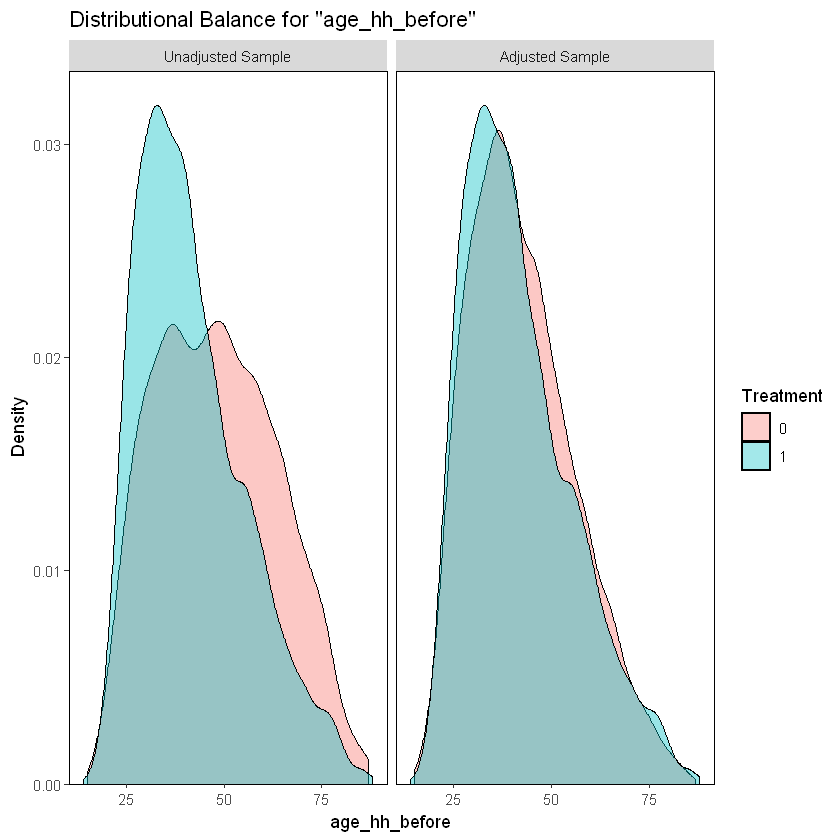

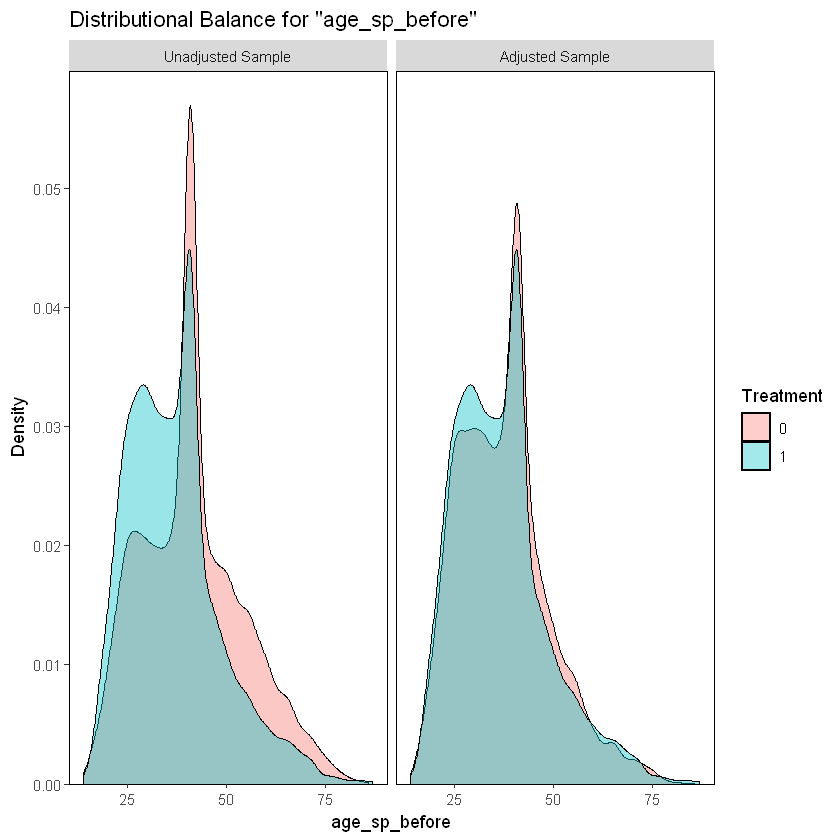

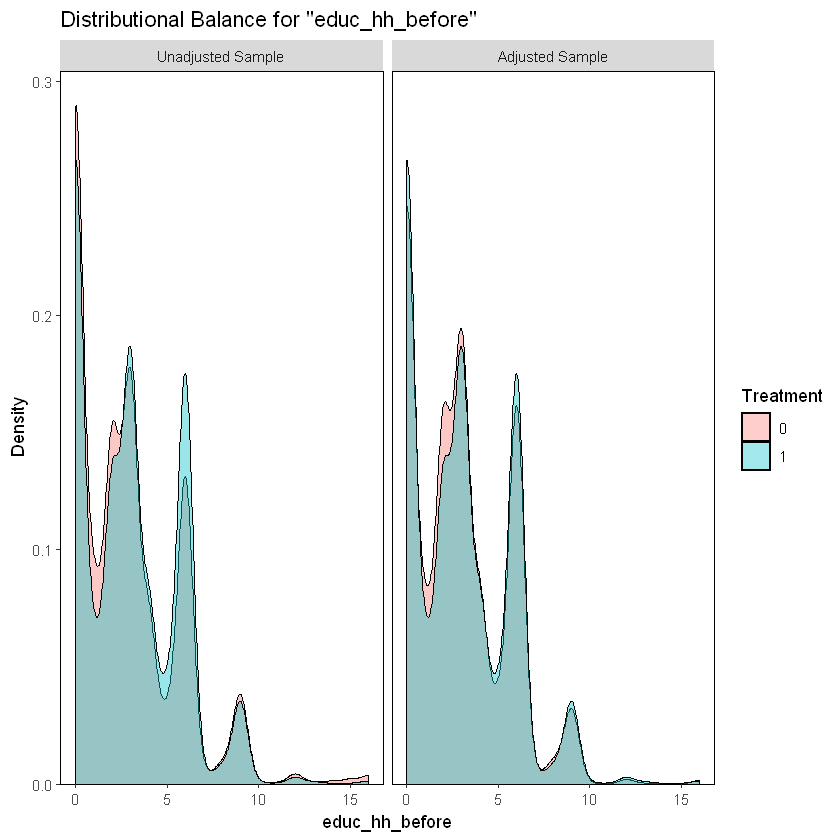

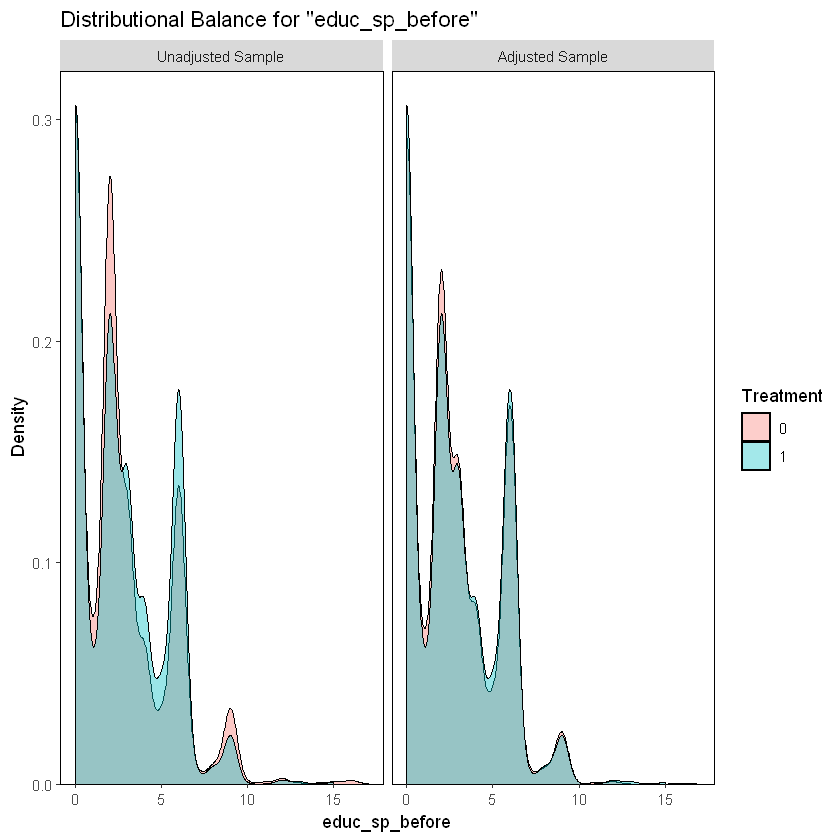

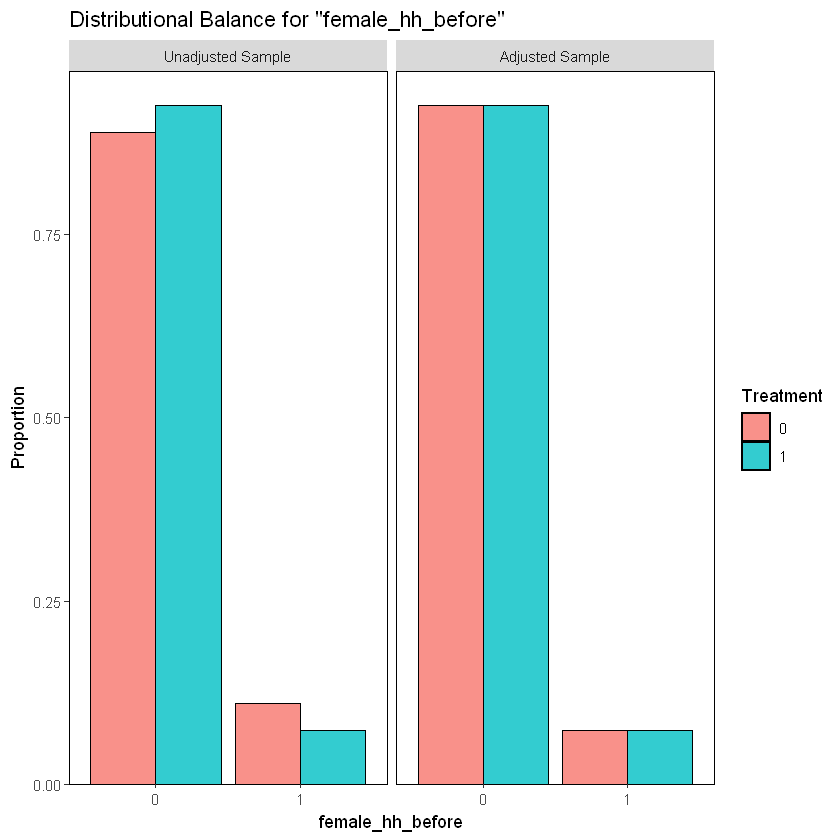

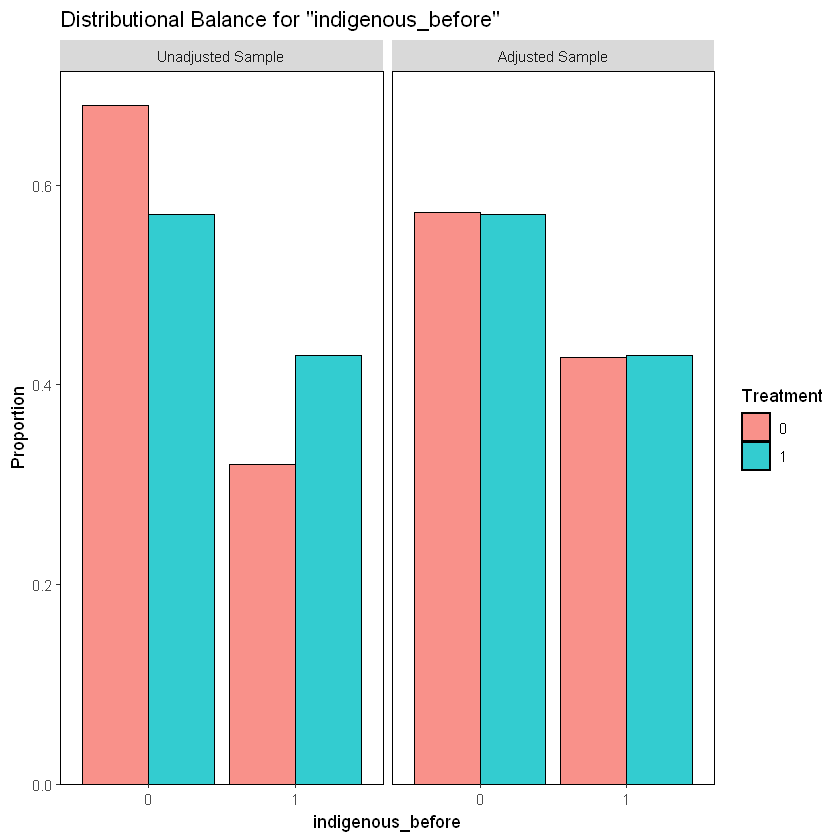

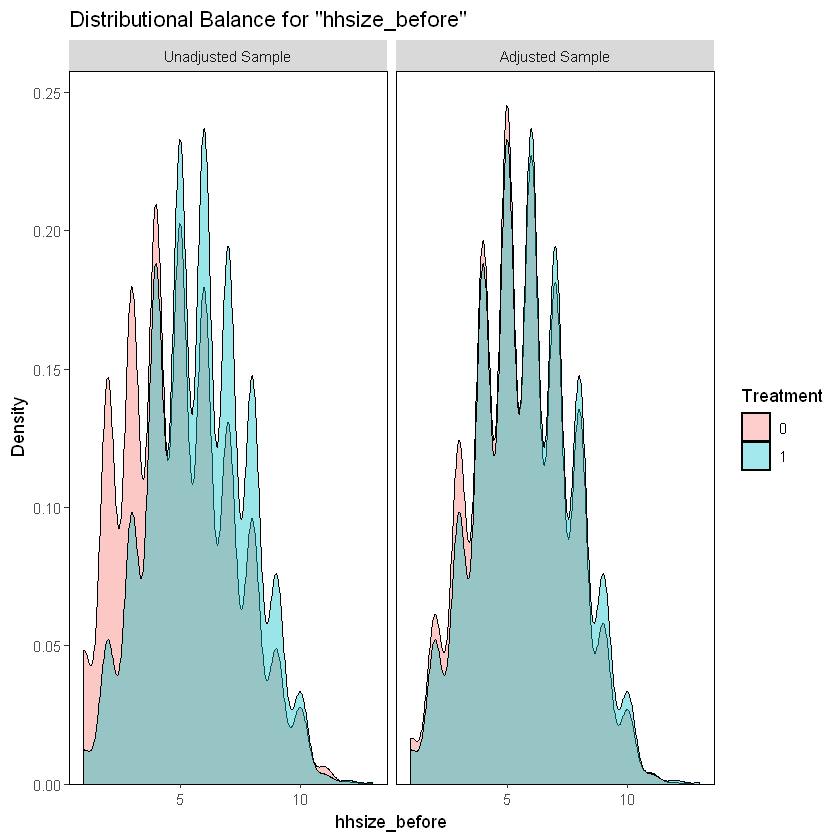

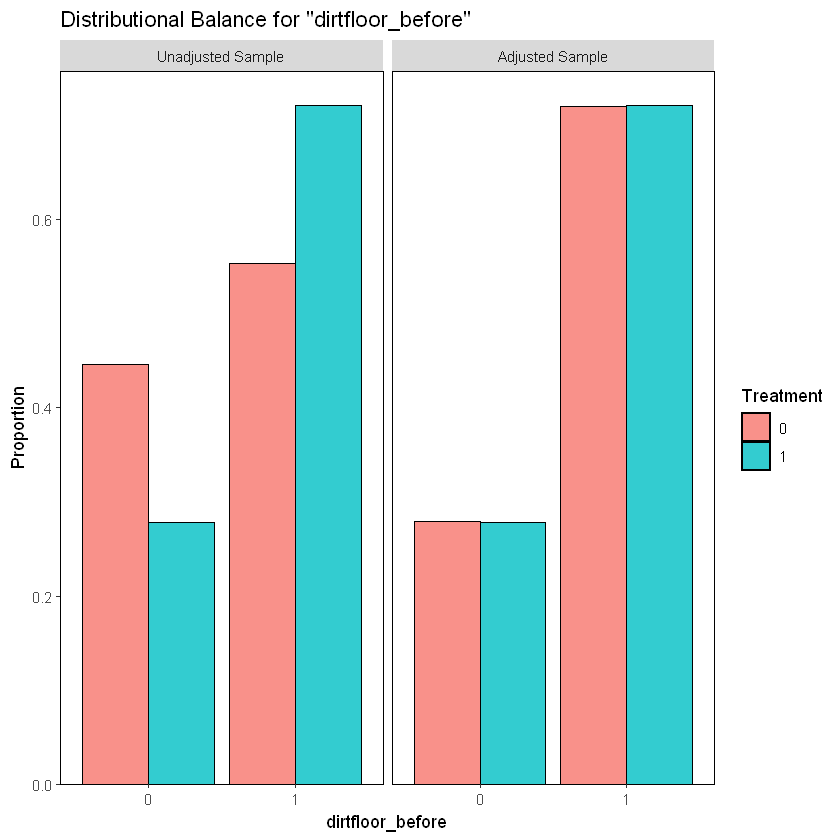

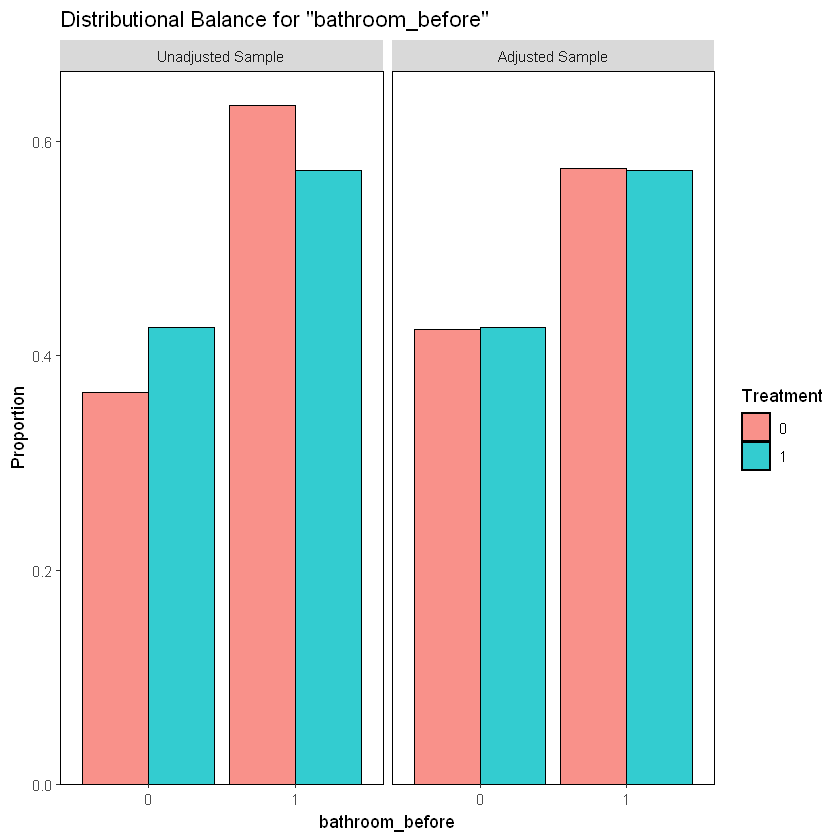

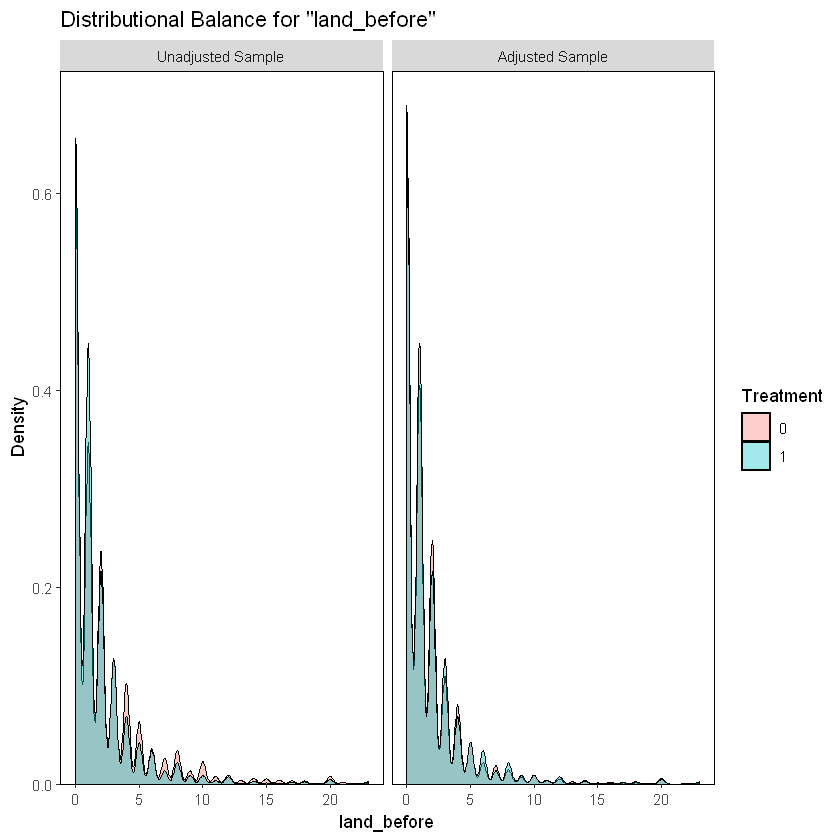

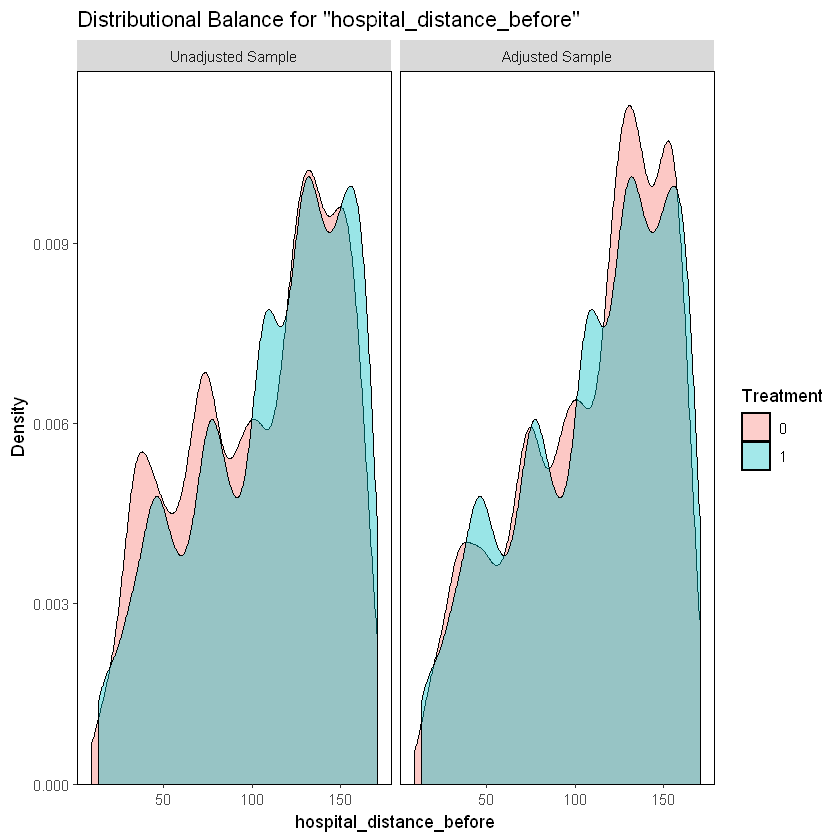

In [18]:
bal.plot(mout, "age_hh_before", which="both")
bal.plot(mout, "age_sp_before", which="both")
bal.plot(mout, "educ_hh_before", which="both")
bal.plot(mout, "educ_sp_before", which="both")
bal.plot(mout, "female_hh_before", which="both")
bal.plot(mout, "indigenous_before", which="both")
bal.plot(mout, "hhsize_before", which="both")
bal.plot(mout, "dirtfloor_before", which="both")
bal.plot(mout, "bathroom_before", which="both")
bal.plot(mout, "land_before", which="both")
bal.plot(mout, "hospital_distance_before", which="both")

The above plots allow us to visualize the distributions across control and treatment before and after matching. This allows us to see how the matching process affected the distributions. We can see that the distributions are quite similar after matching. The only variable that seems to be a bit different is the household size. These plots can be hard to understand so lets use the love.plot() function to visualize the difference in means across the two groups pre and post matching.

#### Using the love.plot() function to display covariate balance in a small summary table.

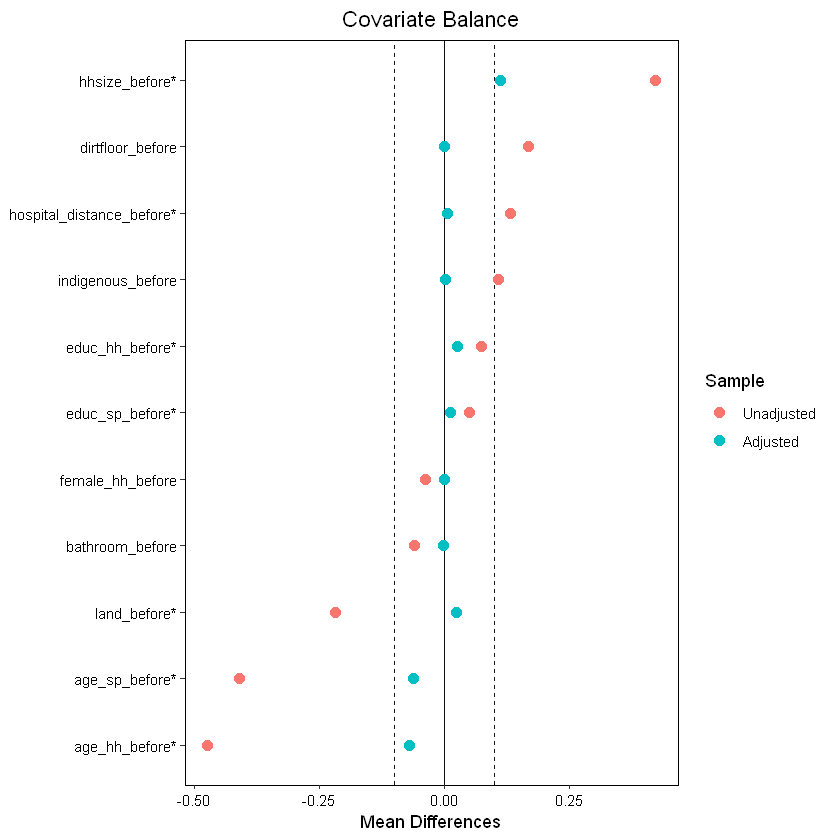

In [19]:
love.plot(bal.tab(mout), stat = "mean.diffs", threshold = 0.1, var.order = "unadjusted", stars = "std")

Looking at the plot above, we see that the algorithm was able to perform quite well as the difference of means in the matched dataset all lie well within the threshold and even the Household size is almost within the threhsold as compared to the gigantic difference in the unmatched dataset. This shows that the algorithm was able to balance the covariates quite well. This is the reason that the matching method is able to extract a much better estimate of the treatment effect as compared to the regression model as the covariate balance is much more balanced across the treatment and control groups.

# Step 6: Differences-In-Differences

In this part, we are going to estimate the causal effect using observational data alone with a difference-in-difference approach. We have data indicating if households were enrolled in the program (enrolled) and data indicating if they were surveyed before or after the intervention (round), which means we can find the differences between enrolled/not enrolled before and after the program. Since diff-in-diff needs data over time you should use the entire dataset and not the "After" or "Before" datasets.



1. Run a regression model that estimates the difference-in-difference effect of being enrolled in the HISP program. What is the causal effect of HISP on health expenditures?
2. Run a second model that estimates the difference-in-difference effect, but control for the following variables: age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance. How does the causal effect change?
3. Show the results from the two regressions in a side-by-side table.
4. Is the parallel trends assumption satisfied? How do you check?

In [20]:
ols_model <- lm(health_expenditures ~ enrolled_num * round, data = world_bank)
ols_model_2 <- lm(health_expenditures ~ enrolled_num * round + age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance, data = world_bank)
stargazer(ols_model, ols_model_2, type = "text", title="Regression results", column.labels = c("DID model", "DID model with covariates"))


Regression results
                                           Dependent variable:                    
                        ----------------------------------------------------------
                                           health_expenditures                    
                                 DID model             DID model with covariates  
                                    (1)                           (2)             
----------------------------------------------------------------------------------
enrolled_num                     -3.882***                     -0.829***          
                                  (0.180)                       (0.147)           
                                                                                  
roundAfter                        2.336***                     2.264***           
                                  (0.139)                       (0.111)           
                                                                   

In order to estimate the causal effect from the difference-in-difference approach and using a regression, we use the coefficient of the interaction term between the time-period variable and the treatment variable.  
1. In the model without controlling for variables, we find the treatment effect to be -8.985.  
2. In the model with controlling for variables, we find the treatment effect to be -8.985 as well. The causal estimate did not change even after controlling for covariates. This might be because the DiD method is much less prone to change based on the functional form used even though using a regression instead of just means allows us to control for variables just in case. Using just means would have given similar if not the same result.  
3. In order to check for the paralell trends assumption, we don't have a statisical test and most often it is tested using visualization of the pre-treatment data. However, in this case, that is not possible as we only have data for two points in time, before & after treatment, we can't visualize the trends either so we can't really check for the parallel trends assumption.

# Step 7: Regression Discontinuity: Basics

Eligibility for the HISP is determined by income. Households that have an income of less than 58 on a standardized 1-100 scale (poverty_index) qualify for the program and are automatically enrolled. Because we have an arbitrary cutoff in a running variable, we can use regression discontinuity to measure the effect of the program on health expenditures.

For this step, you should use the world_bank_after dataset.

1. Using the dataset above, determine if the discontinuity is sharp or fuzzy. (Hint: create a scatterplot with poverty_index on the x-axis, enrolled on the y-axis, and a vertical line at 58). You can also show a table to prove whether it's sharp or fuzzy.
2. Determine if the distribution of the running variable (poverty_index) has a jump near the cutoff (it shouldn't). (Hint: create a histogram with poverty_index on the x-axis and a vertical line at 58).
3. Visualize the jump in outcome at the cutoff with a scatterplot (Hint: create a scatterplot with poverty_index on the x-axis, health_expenditures on the y-xis, color by enrolled, add a vertical line at 58, and add trendlines with geom_smooth(method = "lm"). You might want to adjust the size and transparency of the points with geom_point(alpha = 0.2, size = 0.2) or something similar.)
4. Graphically, does it look like the HISP reduces health expenditures?

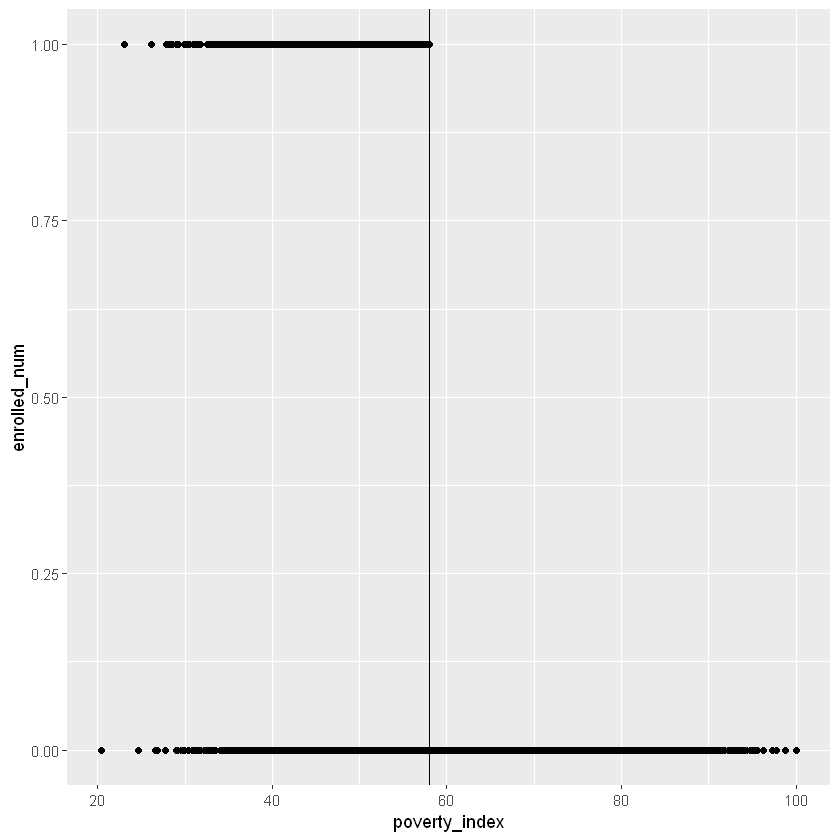

In [21]:
# 1. Creating a scatter plot with poverty_index on the x-axis and enrolled on the y-axis with a vertical line at 58
ggplot(world_bank, aes(x = poverty_index, y = enrolled_num)) +
    geom_point() +
    geom_vline(xintercept = 58)

1. In Sharp RD design, the assignment to treatment is determined completely and precisely by the cutoff value of the continuous variable (proverty_index). There are no other factors influencing the assignment process, and we should see a sharp change in the outcome variable at the cutoff. Fuzzy RD design on the other hand is when the assignment to treatment is determined by the cutoff value of the continuous variable (proverty_index) but there are other factors that influence the assignment process. In the plot above, we see that the discontinuity of eligibility is sharp as there is a clear jump in the enrollment of households at the cutoff value of 58. However, there are still households below the eligibility cutoff that are not enrolled in the program. This indicates that there are other factors that influence the assignment process and the RDD design is fuzzy.

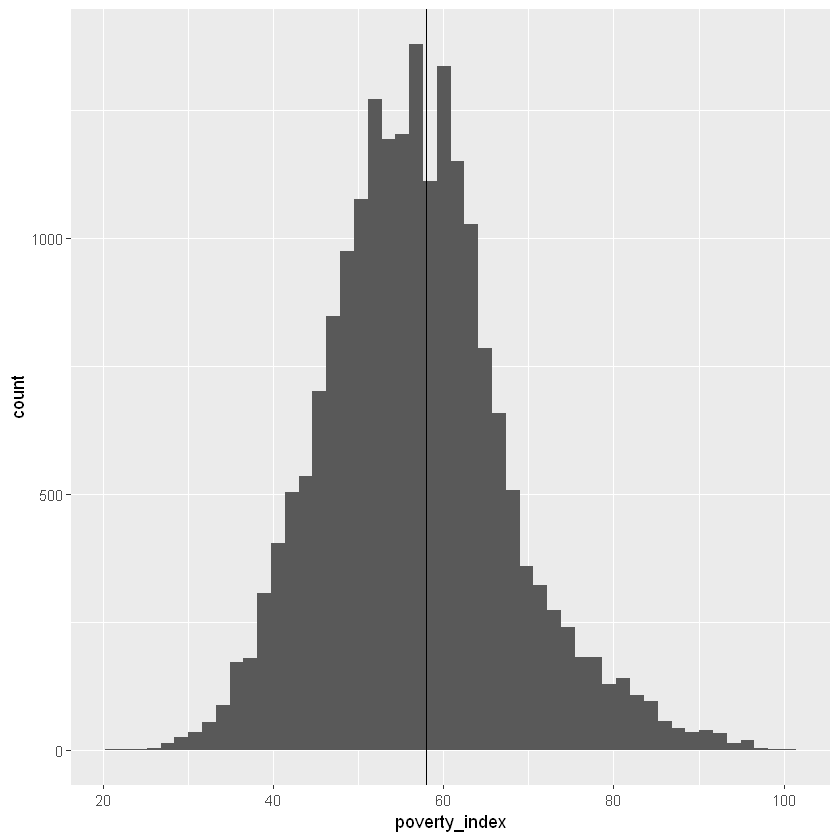

In [22]:
# Making a histogram of poverty_index and a vertical line at 58
ggplot(world_bank, aes(x = poverty_index)) +
    geom_histogram(bins = 50) +
    geom_vline(xintercept = 58)

2. Looking at the histogram, we see no sharp cutoff at 58 and the distribution is continuous. From this, we can see that there is no evident clustering around the cutoff value which indicates that the design is not as prone to manipulation of the running variable. The smoothness of the distribution also indicates that the running variable is distributed well across the range of values.

`geom_smooth()` using formula 'y ~ x'



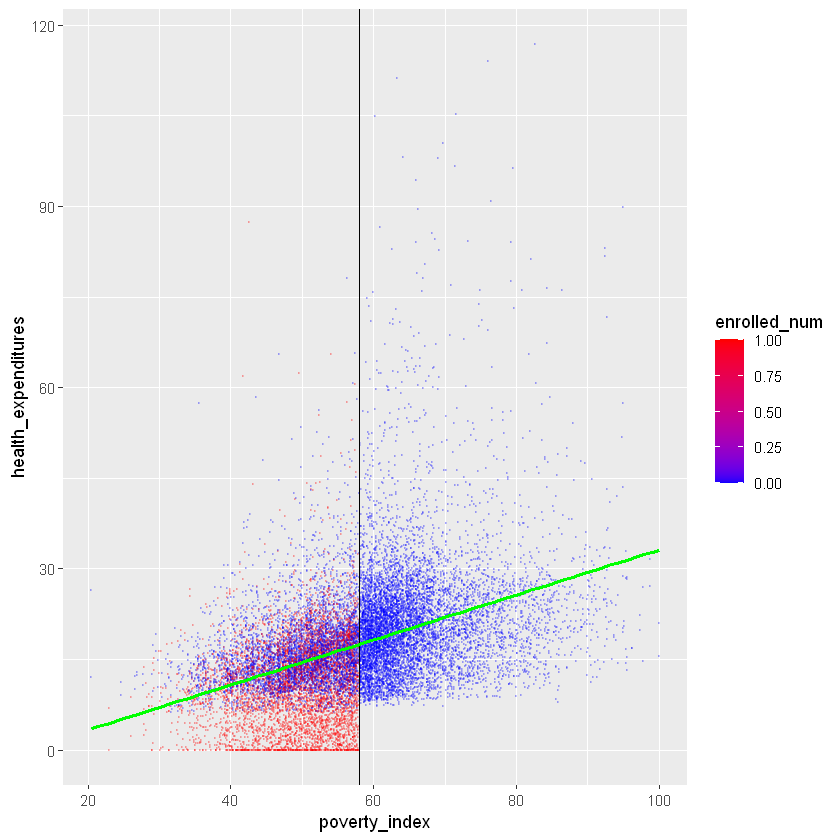

In [23]:
ggplot(world_bank, aes(x = poverty_index, y = health_expenditures, color = enrolled_num)) +
    geom_point(alpha = 0.2, size = 0.2) +
    geom_vline(xintercept = 58) + 
    scale_color_gradient(low = "blue", high = "red") + 
    geom_smooth(method = "lm", color = "green", se = FALSE)

3. Looking at the scatter plot above, we see a clear jump in the outcome variable at the cutoff value. However, due to the large number of data points, the visualization is still hard to read. Thus, we can use the rdplot() function to visualize the RD design.

[1] "Mass points detected in the running variable."


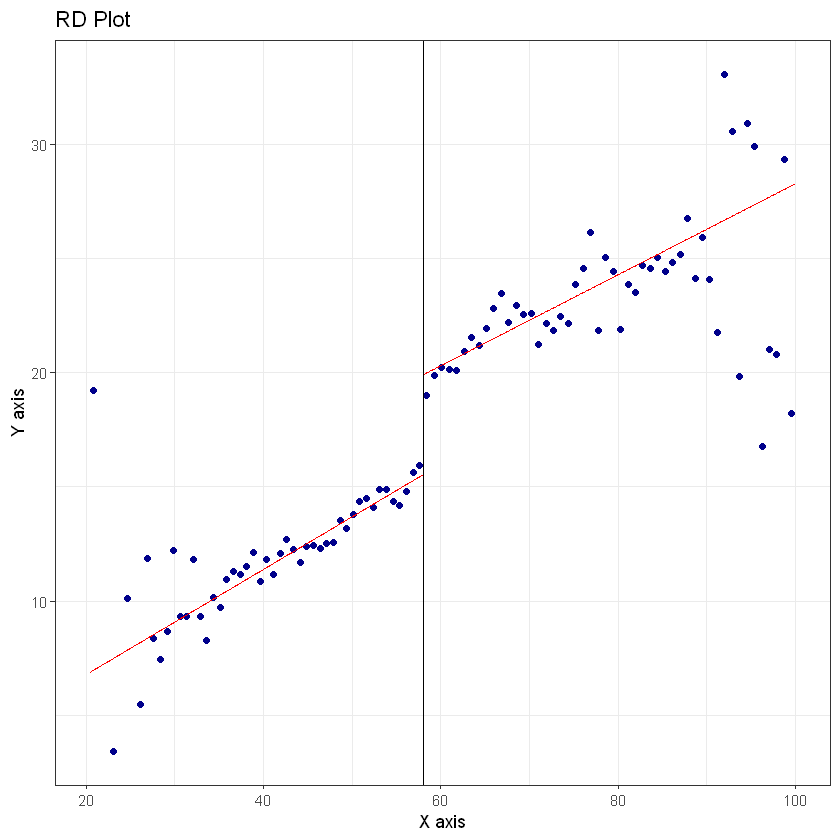

In [24]:
rdplot(y = world_bank$health_expenditures, x = world_bank$poverty_index, c = 58, nbins = 50, p = 1)

Looking at the plot above, we see that there is a clear jump at the cutoff in the outcome variable. A polynomial has also been fit to both the sides of the cutoff to visualize the trends. The observations have been grouped to be 50 datapoints by taking the means so that the plot is cleaner and easier to read.

4. Graphically, since the mean of the outcome variable is lower for the treatment group, it looks like the HISP reduces health expenditures. Moreover, looking at the trend lines, there is a gap between the two fitted trend lines which futher hint at the fact that the HISP reduces health expenditures and there is a treatment effect.

# STEP 8: Regression discontinuity; Estimating effects

Use the rdrobust library to estimate the size of the gap. For the sake of simplicity, just use the default (automatic) bandwidth and kernel. You should again use the world_bank_after dataset.
1. Report all the conventional and Robust coefficients. If you want rdrobust to report the robust coefficients as well, you should set the argument all = TRUE.
2. What is the bandwidth that the package estimates as the "optimal" bandwidth?

In [25]:
rdmodel <- rdrobust(y = world_bank_after$health_expenditures, x = world_bank_after$poverty_index, c = 58, fuzzy = world_bank_after$enrolled_num, all = TRUE)
summary(rdmodel)

[1] "Mass points detected in the running variable."
Call: rdrobust

Number of Obs.                 9914
BW type                       mserd
Kernel                   Triangular
VCE method                       NN

Number of Obs.                 5629         4285
Eff. Number of Obs.            2748         2432
Order est. (p)                    1            1
Order bias  (q)                   2            2
BW est. (h)                   7.147        7.147
BW bias (b)                  12.561       12.561
rho (h/b)                     0.569        0.569
Unique Obs.                     949         1012

        Method     Coef. Std. Err.         z     P>|z|      [ 95% C.I. ]       
  Conventional    -8.932     1.233    -7.245     0.000   [-11.349 , -6.516]    
Bias-Corrected    -8.816     1.233    -7.151     0.000   [-11.233 , -6.400]    
        Robust    -8.816     1.448    -6.089     0.000   [-11.654 , -5.978]    


1. The estimated coefficients for the three methods, Conventional, Bias-corrected, & Robust are -8.932, -8.816, & -8.816 respectively. The standard errors associated with these estimates are 1.233, 1.233, & 1.448 respectively as well indicating that the Robust method has the least precision in the estimate. All the p-values are small indicating high confidence that the coefficients are statistically significant and not due to chance. This means that the per capital expenditure on health is $8.816 lower for the people enrolled in the program using the robust coefficient.
2. The optimal bandwidth that the package estimates is 7.147. This means that the optimal group for which we would see the treatment effect hold is within 7.147 units of the cutoff value. Hence, the treatment effect can be expected to hold true if the dataset only consisted of households with poverty_index values between 50.853 and 65.147. This value is because RDD only estimates a Local Average Treatment Effect (LATE) and the optimal bandwidth is chosen reflective of the bias-variance tradeoff.

### In the end, in one paragraph, reflect on the methods you used and reflect on why the numbers varied from using regression/matching/weighting vs. diff-in-diff vs. regression discontinuity. 

We used 5 main methods for trying to estimate the causal effect of the HISP program on health expenditures. The first method was a regression run without any controlled confounders after which we ran another regression but this time controlled for all the other observed variables in the dataset. After this we used matching to try and find the best match for each observation in the treatment group followed by a regression using the matched dataset. Our estimates varied a bit as we were trying to fit a line to the various datapoints in order to find the coefficient of the treatment variable.  
After the regressions, we used Differences-in-Differences and while we still used a regression, this time we used it by trying to estimate the changes in the control and treatment groups before and after the treatment. These differences were then compared to find the causal estimate. Finally, we used Regression Discontinuity to estimate the causal effect of the treatment. Here, we used a known cutoff value of the running variable (poverty index) to estimate a causal effect by splitting the dataset into two groups and then comparing them. We also used a robustness check to see if the estimates were robust to the choice of bandwidth.  
We saw some variation in the estimates of the regression methods while matching and DiD produced a slightly smaller but still close estimate of the causal effect. This is because we used a similar method in all of these where we were trying to estimate the treatment effect by finding the coefficient of the variable. However, since the methods vary slightly in the way they are structured, we were observing some variation in the estimates. During the initial regressions, we were using the full datasets which meant that the model was trying to fit a line to the entire set of treatment and control variables before finding the estimate. After matching, we removed a lot of control observations to make the covariate balanace much better in the groups. This meant that the regression coefficient was now trying to fit a line to a much smaller set of datapoints which were more comparable. DiD led to a different estimate because it relies a lot on the paralell trends assumption holding which is not always the case. Unfortunately, since we do not have observations extending back in time, we could not check this assumption. Similarly, RDD relies on the assumption of smoothness at the cutoff which means that the method differs in terms of estimation methods. RDD only estimates Local Average Treatment Effect instead of the ATT which we see in most other methods because the choice of bandwidth is crucial to the estimate. The method relies on the assumption that the datapoints near the cutoff are quite comparable and not very different which allows the comparison.

# Question 2: Interpreting Instrumental Variables

## Step 1

The research paper uses four different measures of autonomy. What are those?

The paper uses 5 dichotomous variables (binary) to measure autonomy. They can be represented as whether or not (coded as 0 for No and 1 for Yes) the woman involved, by herself or jointly with her husband or other family members in deciding to:
1. Obtain health care for herself.
2. Purchase jewelry.
3. Go and stay with her natal family and siblings.
4. Set money aside for herself.

## Step 2

To address the endogeneity, Eswaran, and Malhotra used two instruments for domestic violence. Find those instruments in the paper and mention them here.

The two instrumental variables used in the paper are:
1. The height of the woman. This was standardized as the variation in height is too much across India and then measured as the deivation from the mean height of the state.
2. Whether or not the woman is breast-feeding a child.

## Step 3

One of the instruments is related to a woman’s physical characteristics. In one paragraph, discuss whether the choice of this instrument makes sense to you (Note, you should talk about the three assumptions).

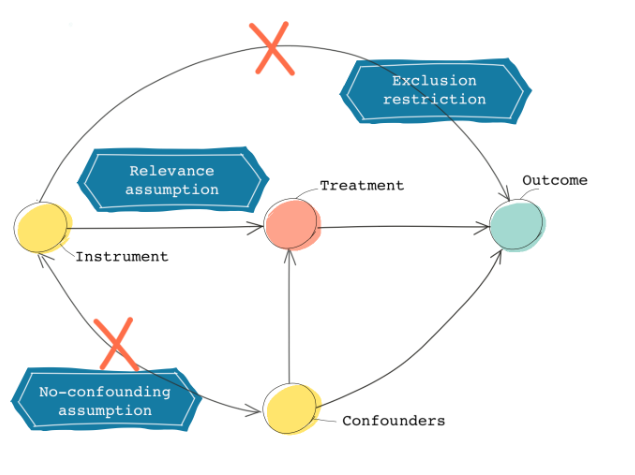

In [26]:
image_file <- "Instument-assumptions.png"
image <- readBin(image_file, "raw", file.size(image_file))
display_png(image)

There are three main assumptions when assessing whether an instrument makes sense or not:
1. Relevance
2. Exclusion-restriction
3. Non-confounding

These are also visualized in the picture above.

In this case, the instrument of height is not imposed by the researchers and is something that is pre-determined beforehand. The paper mentions that height satisfies the relevance assumption as a husband is likely to be physically abusive if he believes that he can physically overpower his wife. We would expect that taller wives would be less prone to physical abuse. This was also assumed to be randomized and not be affected by the man's preferences before marriage as in India most marriages are arranged and the two people getting married often do not see each other physically before marriage.  
The second assumption of exclusion restriction refers to the part that the instrument should not affect the outcome variable directly i.e. the affect of the instrument on the outcome should be through the treatment variable. This assumption seems to be valid as the authors do control for income level which they propose as an alternative path in a DAG model. There are issues though as the cultural trends in India could propose that a woman who is taller could be physically imposing and thus have more autonomy over resource management in the household along with lesser domestic violence or in another case, since taller women don't do well in the "marriage market", they could have less self-esteem and thus be more prone to domestic violence. Thus, they could affect the outcome directly.  
The final assumption is the non-confounding assumption which states that the instrument should not share a cause with the outcome i.e. there should not be alternative paths that connect the instrument to the outcome. This assumption is potentially not satisfied in this case because there could be many factors that affect both the height of the woman and the domestic violence she faces. One of these could be that the woman is from a household that had a low income level along with low healthcare which affect her height and also her chances of being abused as the authors found that lower incomes were indeed associated with higher levels of domestic violence. If we take self-esteem as a variable, we could also see that a taller woman could have less self-esteem and thus, be more prone to domestic violence.  
Taking into account the disucssion above, the instrument is not perfect but it does to an extent satisfy the three assumptions. Thus, one could potentially argue that the instrument is valid. However, we should be cautious in interpreting the results as the instrument is not perfect.

## STEP 4

Why do you think the researchers included Chart 1 (p. 31) in the paper?

Chart 1 combined with Table 3 above it acts as an analysis of the instruments that the authors used. A good instrument would act as a good predictor of the treatment. This can be done through using correlation which is what they have done in Table 3 where they showed how good of a predictor is the instrument for whether or not the husband has beaten the wife in the past 12 months. The chart is a bar chart of mean domestic violence against the height index which is a group of women divided by their relative heights. This tests the hypothesis the authors mentioned before that height is relevant to the study at hand predicting that we should see lesser domestic violence as the height increases as physically overwhelming the wife is a big factor in the level of domestic violence observed. This prediction seems to hold as we see that as height increases, the mean domestic violence goes down. Hence, the instrument is relevant to the treatment.

## STEP 5

What do you understand from Table 9 in the paper? What does this table tell you about the results based on OLS? Explain everything in no more than 300 words. 

The table shows the effect of the treatment on the outcome variables. Here the outcome variables were 4 in number so we see how the treatment impacts each of the measures of women autonomy. The table compares the estimate through a simple OLS regression, a two-stage least squares regression using just height as an instrument, a 2SLS using just breast-feeding as an instrument and finally a 2SLS using both height and breast-feeding as instruments. The first column shows the effect of domestic violence on autonomy when it comes to the decision to stay with her natal family followed by decision to buy jewelry for herself. The third column is the effect on ability to obtain healthcare for herself and the final column is the effect on ability to set aside money for herself.  
The OLS regression finds coefficients that are all significant at the 1% level for all four of them with coefficients of -0.042, -0.048, -0.036, and -0.028 respectively. This means that on average, women who have faced domestic violence in the past 12 months have a 4.2% smaller chance of being able to decide to stay with her natal family, a 4.8% lesser chance of being able to buy jewelry for herself, a 3.6% lesser chance of being able to obtain healthcare for herself and a 2.8% lesser chance of being able to set aside money for herself. The standard errors associated with these estimates are also shown. This sums up the negative impact of domestic violence on women's autonomy in the household.  
The following rows find much higher estimates but using just one instrument, we don't see as many significant results with height not having a significant effect for decision to stay with natal family and breast-feeding not having a significant effect on decision to set aside money for herself. The standard errors for these estimates are also quite big. However, in the final row when both the instruments are used together, all the estimates are significant at the 5% level with three of them being significant at the 1% level indicating that these effects are not due to chance. The standard errors are also smaller as compared to the other instrument regressions which hints at a higher precision of the estimates.

## STEP 6

What is the reason the authors included Table 10 (first-stage regression) in the paper? Briefly and intuitively explain. 

The first stage regression represents the relationship between the instrument and the treatment variable. First-stage regression tables are often used to show Intention-to-treat (ITT) effect of the instrument variable on the treatment. Such tables test the strength and relevance of the IVs in addressing the endogeneity of the treatment variable. If the coefficients associated with IVs are significant in our first-stage regressions, it establishes the endogeneity as well indicating that IVs are necessary to address it. Using multiple models also acts as a robustness check with consistent results across models acting as a backing for validity & strength of the IV. Finally, first-stage regressions also allow transparency in the process of IV estimation allowing the reader to understand the process of IV estimation.  
Each row indicates the variable that they used in the regression with the three columns showing the coefficients for each of the three models that they used (breast-feeding as instrument, height as instrument and both as instruments). The first column shows the model where both instruments were used followed by when only breast-feeding was used and the final column is when only height as an instrument was used. The first two rows correspond to these variables. All the rows after that are the control variables that they used in the regression.  
Looking at the first row, both models that used breast-feeding as an instrument found the same coefficient of 0.014 which means that if the woman is currently breast-feeding, she has a 1.4% higher chance of having been beaten by her husband in the past 12 months. The standard errors are also quite small which means that the estimates are precise. Similarly, the second row which is the deviation of the height of the woman from the mean shows that the coefficient is -0.001 which means that women who are further from the mean have a lower chance of having been beaten by their husband in the past 12 months. The coefficient is quite small though despite being significant which doesn't seem to be a very good predictor of domestic violence.

# Optional Question: Location based Natural Experiments

#### Introduction
Taiwan is one of the countries that gained independence following World War II in 1949 along with many others such as Pakistan, India, Bangladesh etc. following the global powers suffering major economic & humanitarian losses which rendered them unable to rule over their colonies. However, unlike many of these countries, Taiwan never fully gained independence on the international stage, with China maintaining its stance that the island of Taiwan is still a part of Mainland China. Taiwan still doesn't have a seat in the United Nations (Shankar, 2022) and is still considered a part of China by many countries. In comparison, Pakistan and India have been recognized as independent countries by the United Nations and have been active members since 1947 and 1945 respectively.  
This study will focus on how this disputed status has impacted the country in terms of its economy. However, since we don't have a large enough sample size of countries with disputed stauses, we can use the Synthetic control method. This method uses a large number of control countries to create a synthetic control country that is similar to the treatment country in terms of its pre-treatment characteristics. This synthetic control country is then used to compare the treatment country's post-treatment characteristics to see how the treatment country has changed. We will carefully select relevant economic indicators to measure Taiwan's economic condition, such as GDP, trade, investment, and employment.  
By comparing Taiwan's post-treatment economic outcomes with those of the synthetic control country, we can estimate the causal effect of Taiwan's disputed status on its economy. We will also consider potential confounding factors, such as domestic policies, global economic trends, and other contextual factors that may affect Taiwan's economic condition.  
The findings of this study could provide valuable insights into the economic consequences of Taiwan's disputed status and contribute to the literature on the intersection of politics and economics. However, we acknowledge potential limitations, including the availability and quality of data, assumptions of the Synthetic Control Method, and the complex nature of international relations. Nevertheless, our study aims to provide evidence-based analysis that can inform policymakers and stakeholders interested in Taiwan's economic development in the context of its disputed status.  
In conclusion, this study will contribute to our understanding of the impact of Taiwan's disputed status on its economic condition using the Synthetic Control Method. The results of this research could have implications for policymakers and provide insights into the broader implications of political disputes on economic outcomes.  
#### Countries of Interest
It is important that we find countries that gained independence around the same time and are somewhat similar to Taiwan in terms of their characteristics so that they can be used as part of the control group. The following is a list of countries that gained independence following WWII and might be relevant(Historian, n.d.):
- Indonesia
- Vietnam
- Philippines
- Pakistan
- Bangladesh
- India
- Sri Lanka
- South Korea
- Malaysia
- Singapore
- Hong Kong
- Palestine
- Israel

Out of these countries, some have had a hard time with independence and been part of many conflicts which allows us to remove them from our study as they would not make a good part of the donor pool. Palestine and Israel have been involved in conflicts for the past 70 years with no borders defined and economic development almost non-existent which means that they can be removed. Hong Kong and Sri Lanka have both been involved in independence conflicts of their own with Sri Lanka not fully declaring independence till 1972 and Hong Kong being a part of China till 1997 with its status still disputed by many. Thus, they can also be removed. Bangladesh was also a part of Pakistan till 1971 and thus, it can also be removed from the control group. Vietnam also faced a lot of conflicts along with many years under a UN ceasefire and is thus being removed from the control group. This leaves us with a donor pool:
- Indonesia
- Philippines
- Pakistan
- India
- South Korea
- Malaysia
- Singapore

Data for all these countries can be found here: https://tinyurl.com/ss154-quasi-experiments. Data for Taiwan has been taken from (Statistics, 2023). Data for the rest of the countries has been taken from the World Bank's official data source (World Bank, n.d.).


#### Data
The first and foremost step for this method is deciding on which variables to use. We will identify an economic indicator as the outcome variable and we can use **GDP per capita** for this experiment. We also need a set of control variables that are similar to the outcome variable that we shall use to create the synthetic control country. We will use **Unemployment rate, Economic Growth rate, Total population, and Foreign exchange reserves** as our control variables. The main issue here is that the data we need is pre-treatment which I could not find for before 1949 despite searching through various sources. The best source I found was from the World Bank and thus, looking at the scope of this assignment, I am assuming that the treatment took place in 2015. We shall use data from 2000 to 2019 for all the variables using data from January of the preceding year in cases where the data is available on a monthly chart. We exclude data from 2019 onwards due to the onset of Covid-19 which caused a global economic recession which impacted different countries in different manners and we don't want the impact of Covid-19 to be a confounding factor in our analysis. Therefore, 2000 to 2015 acts as our pre-treatment period and 2015 to 2019 acts as our post-treatment period.

#### Analysis
Now that we have our data and variables, we can start the analysis. We will first create a synthetic control country using the control variables and then compare the outcome variable of the treatment country with that of the synthetic control country. Check code cell below.

In [27]:
data <- read.csv("https://tinyurl.com/ss154-quasi-experiments")
data$foreign_exchange_reserves <- as.numeric(data$foreign_exchange_reserves)
head(data)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


,id,country,year,gdp_per_capita,unemployment_rate,economic_growth_rate,population,foreign_exchange_reserves,X,X.1,...,X.14,X.15,X.16,X.17,X.18,X.19,X.20,X.21,X.22,X.23
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,<lgl>,...,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,Taiwan,2000,14844,2.74,6.02,22000000,143000,NA,NA,...,NA,NA,NA,NA,NA,"106,800,003","111,700,001","126,199,999","122,299,995","121,899,996"
2,1,Taiwan,2001,13357,3.35,1.45,22300000,101000,NA,NA,...,NA,NA,NA,NA,NA,,,,,
3,1,Taiwan,2002,13651,5.14,1.82,22400000,103000,NA,NA,...,NA,NA,NA,NA,NA,,,,,
4,1,Taiwan,2003,14040,5.03,5.17,22600000,47000,NA,NA,...,NA,NA,NA,NA,NA,,,,,
5,1,Taiwan,2004,15290,4.53,6.93,22600000,97000,NA,NA,...,NA,NA,NA,NA,NA,,,,,
6,1,Taiwan,2005,16427,4.06,3.76,22700000,53000,NA,NA,...,NA,NA,NA,NA,NA,,,,,


In [28]:
treated_unit <- "Taiwan"
control_units <- c("Phillipines", "Pakistan", "India", "Malaysia", "Singapore", "Indonesia", "South Korea")

dataprep.out <-
    dataprep(foo = data,
             predictors = c("unemployment_rate" , "economic_growth_rate" , "population", "foreign_exchange_reserves") ,
             predictors.op = "mean",
             time.predictors.prior = 2000:2015 ,
             dependent = "gdp_per_capita",
             unit.variable = "id",
             unit.names.variable = "country",
             time.variable = "year",
             treatment.identifier = treated_unit,
             controls.identifier = control_units,
             time.optimize.ssr = 2000:2015,
             time.plot = 2000:2019
    )

In [29]:
synth.out <- synth(data.prep.obj = dataprep.out)
synth.tables <- synth.tab(dataprep.res = dataprep.out,
                          synth.res = synth.out
)
synth.tables$tab.w[1:7, ]


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 3762544 

solution.v:
 0.1475875 0.3237081 0.4767927 0.05191167 

solution.w:
 2.657e-07 0.169297 1.715e-07 6.7e-08 1.02e-07 1e-08 0.8307024 



,w.weights,unit.names,unit.numbers
,<dbl>,<chr>,<int>
2,0.000,Phillipines,2
3,0.169,Pakistan,3
4,0.000,India,4
5,0.000,Malaysia,5
6,0.000,Singapore,6
7,0.000,Indonesia,7
8,0.831,South Korea,8


In [30]:
synth.tables$tab.pred[1:4, ]

,Treated,Synthetic,Sample Mean
unemployment_rate,4.246,2.889000e+00,4.298000e+00
economic_growth_rate,4.186,4.408000e+00,5.201000e+00
population,22893750.000,7.183447e+07,2.553805e+08
foreign_exchange_reserves,99500.000,2.668172e+10,3.325122e+10


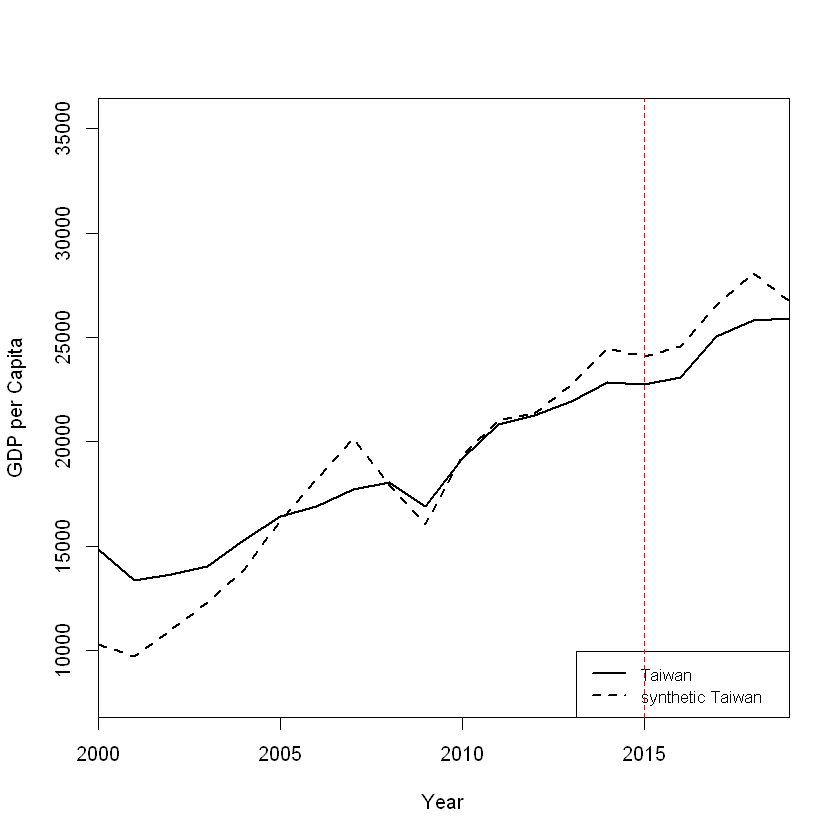

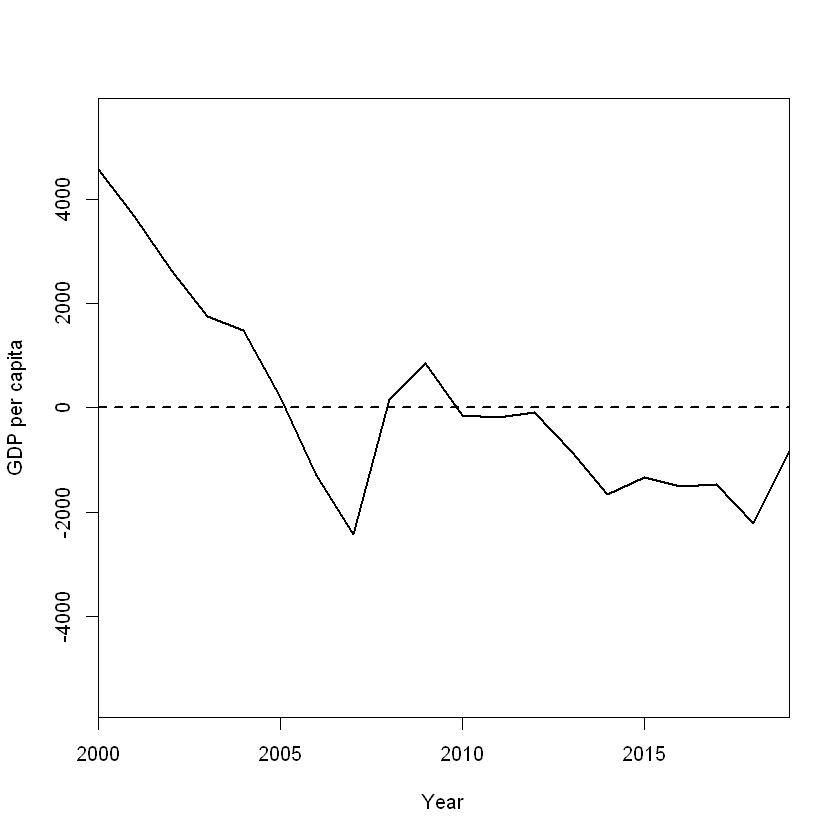

In [31]:
path.plot(synth.res = synth.out,
          dataprep.res = dataprep.out,
          Ylab = "GDP per Capita",
          Xlab = "Year",
          Legend = c("Taiwan","synthetic Taiwan"),
          Legend.position = "bottomright"
)
# Add line for year = 2015 in path plot
abline(v = 2015, col = "red", lty = 2)
gaps.plot(synth.res = synth.out,
          dataprep.res = dataprep.out,
          Ylab = "GDP per capita",
          Xlab = "Year",
          Main = NA
)

In [32]:
# Estimate causal effect
treatment_effect <- data$gdp_per_capita[data$country == treated_unit] - synth.tables$tab.pred[1, ]

# Print estimated causal effect
cat("Estimated Causal Effect of Treatment (Taiwan):", mean(treatment_effect))

Warning message in data$gdp_per_capita[data$country == treated_unit] - synth.tables$tab.pred[1, :
"longer object length is not a multiple of shorter object length"


Estimated Causal Effect of Treatment (Taiwan): 19289.01

From the code above, we see that the treatment effect based on the comparison between Synthetic Taiwan and Taiwan is 19289.01 which indicates that the disputed status has actually had a positive impact on the economy of Taiwan. This is quite surprising as we would have expected the opposite to be true. This result is not a good estimate as our dataset is not representative of our analysis, is only collected over a shorter supposed period and even our Synthetic control is not a good representation as shown in the gaps and path plots above. However, this is the best we can do with the data we have.  

If someone were to find data for the corresponding time period, we could see a much better estimate of the causal estimate and be able to better evaluate whether the synthetic control method can work or not. One more concern here is that the weight allocation is only done to South Korea and Pakistan with South Korea constituting 83.1% of the control subject and Pakistan constituting 16.9% of the control subject. This is a major concern as it means that the synthetic control is not a good representation of the control group as a whole. Finally, our means table also shown above showing the covariate balance between the treatment and synthetic control also shows that the means are quite far apart which is a major concern as it shows the synthetic control does a poor job.

# References

Owens, G. M. (2008, April 14). Gender differences in health care expenditures, resource utilization, and quality of care. Pubmed. Retrieved April 3, 2023, from https://pubmed.ncbi.nlm.nih.gov/18439060/ 

Shankar, P. R. (2022, September 22). UN membership to protect Taiwan. Taipei Times. Retrieved April 10, 2023, from https://www.taipeitimes.com/News/editorials/archives/2022/09/23/2003785772 

Historian, O. of the. (n.d.). Decolonization of Asia and Africa, 1945–1960. U.S. Department of State. Retrieved April 10, 2023, from https://history.state.gov/milestones/1945-1952/asia-and-africa#:~:text=Between%201945%20and%201960%2C%20three,from%20their%20European%20colonial%20rulers.&amp;text=There%20was%20no%20one%20process,only%20after%20a%20protracted%20revolution. 

Statistics, N. (2023). National Statistics, Republic of China (Taiwan). Retrieved April 10, 2023, from https://eng.stat.gov.tw/ 

World Bank, D. (n.d.). Countries and economies. Data. Retrieved April 10, 2023, from https://data.worldbank.org/country/ 